# L2 OOD Experiments
Runs experiments of using independent logistic regressors to perform out of distribution detection on SAR images from the sample dataset

Adapted from Nate's SAR ood experiments script

In [1]:
from __future__ import print_function
import numpy as np
import sys
import os
from collections import defaultdict
import random
import torch
import torch.nn as nn
import torch.utils.data as utilsdata
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as tvdatasets
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import copy

# Custom
import models
import create_split
import Dataset_fromPythonList as custom_dset
import helpers
import training_helpers
import ood_helpers
import calculate_log as callog
%matplotlib inline

In [2]:
# Constants
device = 'cuda' if torch.cuda.is_available() else 'cpu'
DSIZE = 64

In [3]:
# Inputs
# Percentage of measured data for training the sample classifier (range = [0,1])
K = float(0)
# Number of classes to hold out as OOD classes (range = [1, 8])
NUM_HOLDOUT_CLASSES = int(1)
dataset_root = "./SAMPLE_dataset/png_images/qpm"
REPEAT_ITERS = 5
DATASETS = ["ID", "holdout"]
SEED = 1234567
random.seed(SEED)
torch.manual_seed(SEED)

# SAMPLE Classifier Learning Params
num_epochs = 60
batch_size = 128
learning_rate_decay_schedule = [50]
learning_rate = 0.001
gamma = 0.1
weight_decay = 0.
dropout = 0.4

# Normalization Constants for range [-1,+1]
MEAN = torch.tensor([0.5], dtype=torch.float32).view([1,1,1]).to(device)
STD = torch.tensor([0.5], dtype=torch.float32).view([1,1,1]).to(device)

In [4]:
# Initialize stat keepers
CLS = ['l2', 'softmax']
OODS = ['baseline', 'odin', 'odin_ipp', 'mahala', 'mahala_ipp', 'l2']
STAT_accuracy = {}
STAT_ood = {}

for c in CLS:
    STAT_accuracy[c] = []
    STAT_ood[c] = {}
    for ood in OODS:
        STAT_ood[c][ood] = {}
        for dd in DATASETS:
            STAT_ood[c][ood][dd] = defaultdict(list)

In [5]:
# Dataset setup
full_train_list, full_test_list = create_split.create_mixed_dataset_exp41(
    dataset_root, K)
clsmap = helpers.get_class_mapping_from_dataset_list(full_train_list)

Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539


In [6]:
class_counts = torch.zeros((10), dtype=torch.float32).to(device)
for i in full_train_list:
    class_counts[i[1]] += 1
print(class_counts)
print(class_counts.sum())
print(class_counts.sum()- class_counts)
print((class_counts.sum()-class_counts)/class_counts)

tensor([116.,  55.,  43.,  78.,  75.,  76.,  75., 116.,  56., 116.],
       device='cuda:0')
tensor(806., device='cuda:0')
tensor([690., 751., 763., 728., 731., 730., 731., 690., 750., 690.],
       device='cuda:0')
tensor([ 5.9483, 13.6545, 17.7442,  9.3333,  9.7467,  9.6053,  9.7467,  5.9483,
        13.3929,  5.9483], device='cuda:0')


In [7]:
for cls_method in CLS:
    for holdout in range(10):
        holdout_classes = [holdout]
        for ITER in range(REPEAT_ITERS):
            print(20*"*")
            print("Starting Iter: {}/{} for K={}, J={}, Cls={}, Holdout={}".format(
                ITER, REPEAT_ITERS, K, NUM_HOLDOUT_CLASSES, cls_method, holdout))
            print(20*"*")
            # Make datasets
            ID_trainlist, ID_testlist, OOD_testlist, bce_weights = \
                create_split.create_dataset_splits(dataset_root, K, holdout_classes)
            ID_trainloader, ID_testloader, OOD_testloader = create_split.get_data_loaders(
                ID_trainlist, ID_testlist, OOD_testlist, dsize=DSIZE, batch_size=batch_size)
            
            # Model Setup
            net = models.resnet18(
                num_classes=10-NUM_HOLDOUT_CLASSES,
                drop_prob=dropout,
                cls_method=cls_method).to(device)
            
            # Training loop
            checkpoint_prefix='ckpts/{}_K{}_J{}_SEED{}_ITER{}_HLD{}'.format(
                cls_method, K, NUM_HOLDOUT_CLASSES, SEED, ITER, holdout)    
            net, final_test_acc = training_helpers.train_model(
                net, num_epochs, ID_trainloader,
                checkpoint_prefix=checkpoint_prefix,
                data_mean=MEAN, data_std=STD, lr=learning_rate,
                weight_decay=weight_decay, scheduler=[50],
                testloader=ID_testloader, weights=bce_weights,
            )
            STAT_accuracy[cls_method].append(final_test_acc)
            
            # OOD Evaluation
            net.eval()
            helpers.save_checkpoint(
                {'test_acc': final_test_acc, 'state_dict': net.state_dict()},
                False,
                'ckpts/{}_K{}_J{}_SEED{}_ITER{}_HLD{}_final'.format(
                    cls_method, K, NUM_HOLDOUT_CLASSES, SEED, ITER, holdout))

********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=l2, Holdout=0
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [0]
Remaining Classes:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
# ID Train:  690
# ID Test:   481
# OOD Test:  58
NEW TRAINING CLASS MAPPING:  {0: 'bmp2', 1: 'btr70', 2: 'm1', 3: 'm2', 4: 'm35', 5: 'm548', 6: 'm60', 7: 't72', 8: 'zsu23'}
NEW TESTING CLASS MAPPING:   {0: 'bmp2', 1: 'bt

	Epoch [ 48 / 60 ]; TestAccuracy: 0.88773 TestLoss: 0.29634
Epoch [ 49 / 60 ]; lr: 0.001 TrainAccuracy: 0.96522 TrainLoss: 0.27128 %-Real: 0.0
	Epoch [ 49 / 60 ]; TestAccuracy: 0.85239 TestLoss: 0.33521
Epoch [ 50 / 60 ]; lr: 0.001 TrainAccuracy: 0.98261 TrainLoss: 0.25137 %-Real: 0.0
	Epoch [ 50 / 60 ]; TestAccuracy: 0.89605 TestLoss: 0.30370
Saving...
Epoch [ 51 / 60 ]; lr: 0.001 TrainAccuracy: 0.98261 TrainLoss: 0.24131 %-Real: 0.0
	Epoch [ 51 / 60 ]; TestAccuracy: 0.86486 TestLoss: 0.31236
Epoch [ 52 / 60 ]; lr: 0.001 TrainAccuracy: 0.97826 TrainLoss: 0.24371 %-Real: 0.0
	Epoch [ 52 / 60 ]; TestAccuracy: 0.89189 TestLoss: 0.28148
Epoch [ 53 / 60 ]; lr: 0.001 TrainAccuracy: 0.97536 TrainLoss: 0.22516 %-Real: 0.0
	Epoch [ 53 / 60 ]; TestAccuracy: 0.88773 TestLoss: 0.28578
Epoch [ 54 / 60 ]; lr: 0.001 TrainAccuracy: 0.97391 TrainLoss: 0.23092 %-Real: 0.0
	Epoch [ 54 / 60 ]; TestAccuracy: 0.86902 TestLoss: 0.27889
Epoch [ 55 / 60 ]; lr: 0.001 TrainAccuracy: 0.98116 TrainLoss: 0.21440 %

	Epoch [ 37 / 60 ]; TestAccuracy: 0.81913 TestLoss: 0.45810
Saving...
Epoch [ 38 / 60 ]; lr: 0.001 TrainAccuracy: 0.92174 TrainLoss: 0.36739 %-Real: 0.0
	Epoch [ 38 / 60 ]; TestAccuracy: 0.77755 TestLoss: 0.44793
Epoch [ 39 / 60 ]; lr: 0.001 TrainAccuracy: 0.94058 TrainLoss: 0.35723 %-Real: 0.0
	Epoch [ 39 / 60 ]; TestAccuracy: 0.81913 TestLoss: 0.40244
Epoch [ 40 / 60 ]; lr: 0.001 TrainAccuracy: 0.94638 TrainLoss: 0.32477 %-Real: 0.0
	Epoch [ 40 / 60 ]; TestAccuracy: 0.85447 TestLoss: 0.36714
Saving...
Epoch [ 41 / 60 ]; lr: 0.001 TrainAccuracy: 0.95072 TrainLoss: 0.31704 %-Real: 0.0
	Epoch [ 41 / 60 ]; TestAccuracy: 0.85031 TestLoss: 0.37661
Epoch [ 42 / 60 ]; lr: 0.001 TrainAccuracy: 0.95072 TrainLoss: 0.31010 %-Real: 0.0
	Epoch [ 42 / 60 ]; TestAccuracy: 0.83784 TestLoss: 0.38635
Epoch [ 43 / 60 ]; lr: 0.001 TrainAccuracy: 0.95942 TrainLoss: 0.29219 %-Real: 0.0
	Epoch [ 43 / 60 ]; TestAccuracy: 0.90644 TestLoss: 0.30324
Saving...
Epoch [ 44 / 60 ]; lr: 0.001 TrainAccuracy: 0.95797 

Epoch [ 26 / 60 ]; lr: 0.001 TrainAccuracy: 0.74638 TrainLoss: 0.58591 %-Real: 0.0
	Epoch [ 26 / 60 ]; TestAccuracy: 0.58628 TestLoss: 0.66287
Epoch [ 27 / 60 ]; lr: 0.001 TrainAccuracy: 0.74928 TrainLoss: 0.57214 %-Real: 0.0
	Epoch [ 27 / 60 ]; TestAccuracy: 0.61123 TestLoss: 0.63259
Saving...
Epoch [ 28 / 60 ]; lr: 0.001 TrainAccuracy: 0.77101 TrainLoss: 0.54520 %-Real: 0.0
	Epoch [ 28 / 60 ]; TestAccuracy: 0.60083 TestLoss: 0.68401
Epoch [ 29 / 60 ]; lr: 0.001 TrainAccuracy: 0.80870 TrainLoss: 0.51564 %-Real: 0.0
	Epoch [ 29 / 60 ]; TestAccuracy: 0.62578 TestLoss: 0.58858
Saving...
Epoch [ 30 / 60 ]; lr: 0.001 TrainAccuracy: 0.83333 TrainLoss: 0.49461 %-Real: 0.0
	Epoch [ 30 / 60 ]; TestAccuracy: 0.64657 TestLoss: 0.58579
Saving...
Epoch [ 31 / 60 ]; lr: 0.001 TrainAccuracy: 0.82754 TrainLoss: 0.48421 %-Real: 0.0
	Epoch [ 31 / 60 ]; TestAccuracy: 0.65281 TestLoss: 0.60212
Saving...
Epoch [ 32 / 60 ]; lr: 0.001 TrainAccuracy: 0.84348 TrainLoss: 0.46926 %-Real: 0.0
	Epoch [ 32 / 60 ];

	Epoch [ 14 / 60 ]; TestAccuracy: 0.52391 TestLoss: 0.76351
Saving...
Epoch [ 15 / 60 ]; lr: 0.001 TrainAccuracy: 0.53333 TrainLoss: 0.82688 %-Real: 0.0
	Epoch [ 15 / 60 ]; TestAccuracy: 0.44283 TestLoss: 0.84448
Epoch [ 16 / 60 ]; lr: 0.001 TrainAccuracy: 0.54493 TrainLoss: 0.80380 %-Real: 0.0
	Epoch [ 16 / 60 ]; TestAccuracy: 0.40748 TestLoss: 0.91296
Epoch [ 17 / 60 ]; lr: 0.001 TrainAccuracy: 0.55362 TrainLoss: 0.79036 %-Real: 0.0
	Epoch [ 17 / 60 ]; TestAccuracy: 0.45530 TestLoss: 0.76326
Epoch [ 18 / 60 ]; lr: 0.001 TrainAccuracy: 0.59420 TrainLoss: 0.76331 %-Real: 0.0
	Epoch [ 18 / 60 ]; TestAccuracy: 0.49480 TestLoss: 0.85728
Epoch [ 19 / 60 ]; lr: 0.001 TrainAccuracy: 0.62609 TrainLoss: 0.74663 %-Real: 0.0
	Epoch [ 19 / 60 ]; TestAccuracy: 0.51143 TestLoss: 0.76844
Epoch [ 20 / 60 ]; lr: 0.001 TrainAccuracy: 0.64928 TrainLoss: 0.70749 %-Real: 0.0
	Epoch [ 20 / 60 ]; TestAccuracy: 0.54470 TestLoss: 0.73602
Saving...
Epoch [ 21 / 60 ]; lr: 0.001 TrainAccuracy: 0.67246 TrainLoss:

	Epoch [ 3 / 60 ]; TestAccuracy: 0.12682 TestLoss: 0.97910
Saving...
Epoch [ 4 / 60 ]; lr: 0.001 TrainAccuracy: 0.22174 TrainLoss: 1.21518 %-Real: 0.0
	Epoch [ 4 / 60 ]; TestAccuracy: 0.12058 TestLoss: 0.94964
Epoch [ 5 / 60 ]; lr: 0.001 TrainAccuracy: 0.24638 TrainLoss: 1.15827 %-Real: 0.0
	Epoch [ 5 / 60 ]; TestAccuracy: 0.11019 TestLoss: 0.97065
Epoch [ 6 / 60 ]; lr: 0.001 TrainAccuracy: 0.28986 TrainLoss: 1.10079 %-Real: 0.0
	Epoch [ 6 / 60 ]; TestAccuracy: 0.21830 TestLoss: 0.95924
Saving...
Epoch [ 7 / 60 ]; lr: 0.001 TrainAccuracy: 0.33768 TrainLoss: 1.03536 %-Real: 0.0
	Epoch [ 7 / 60 ]; TestAccuracy: 0.24324 TestLoss: 0.90146
Saving...
Epoch [ 8 / 60 ]; lr: 0.001 TrainAccuracy: 0.40435 TrainLoss: 1.00114 %-Real: 0.0
	Epoch [ 8 / 60 ]; TestAccuracy: 0.30977 TestLoss: 0.88637
Saving...
Epoch [ 9 / 60 ]; lr: 0.001 TrainAccuracy: 0.43768 TrainLoss: 0.96773 %-Real: 0.0
	Epoch [ 9 / 60 ]; TestAccuracy: 0.35343 TestLoss: 0.82571
Saving...
Epoch [ 10 / 60 ]; lr: 0.001 TrainAccuracy: 0

	Epoch [ 59 / 60 ]; TestAccuracy: 0.91060 TestLoss: 0.25941
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=l2, Holdout=1
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [1]
Remaining Classes:  [0, 2, 3, 4, 5, 6, 7, 8, 9]
# ID Train:  751
# ID Test:   487
# OOD Test:  52
NEW TRAINING CLASS MAPPING:  {0: '2s1', 1: 'btr70', 2: 'm1', 3: 'm2', 4: 'm35', 5: 'm548', 6: 'm60', 7: 't72', 

Epoch [ 48 / 60 ]; lr: 0.001 TrainAccuracy: 0.97470 TrainLoss: 0.25541 %-Real: 0.0
	Epoch [ 48 / 60 ]; TestAccuracy: 0.91170 TestLoss: 0.27537
Epoch [ 49 / 60 ]; lr: 0.001 TrainAccuracy: 0.98003 TrainLoss: 0.23769 %-Real: 0.0
	Epoch [ 49 / 60 ]; TestAccuracy: 0.91992 TestLoss: 0.27657
Epoch [ 50 / 60 ]; lr: 0.001 TrainAccuracy: 0.98668 TrainLoss: 0.21753 %-Real: 0.0
	Epoch [ 50 / 60 ]; TestAccuracy: 0.91170 TestLoss: 0.24122
Epoch [ 51 / 60 ]; lr: 0.001 TrainAccuracy: 0.98003 TrainLoss: 0.22267 %-Real: 0.0
	Epoch [ 51 / 60 ]; TestAccuracy: 0.92197 TestLoss: 0.24220
Saving...
Epoch [ 52 / 60 ]; lr: 0.001 TrainAccuracy: 0.98003 TrainLoss: 0.22217 %-Real: 0.0
	Epoch [ 52 / 60 ]; TestAccuracy: 0.90144 TestLoss: 0.26823
Epoch [ 53 / 60 ]; lr: 0.001 TrainAccuracy: 0.98402 TrainLoss: 0.21333 %-Real: 0.0
	Epoch [ 53 / 60 ]; TestAccuracy: 0.90144 TestLoss: 0.25326
Epoch [ 54 / 60 ]; lr: 0.001 TrainAccuracy: 0.98269 TrainLoss: 0.21389 %-Real: 0.0
	Epoch [ 54 / 60 ]; TestAccuracy: 0.91786 TestLos

Epoch [ 37 / 60 ]; lr: 0.001 TrainAccuracy: 0.94541 TrainLoss: 0.33927 %-Real: 0.0
	Epoch [ 37 / 60 ]; TestAccuracy: 0.41684 TestLoss: 1.05586
Epoch [ 38 / 60 ]; lr: 0.001 TrainAccuracy: 0.94940 TrainLoss: 0.32105 %-Real: 0.0
	Epoch [ 38 / 60 ]; TestAccuracy: 0.51335 TestLoss: 0.82004
Epoch [ 39 / 60 ]; lr: 0.001 TrainAccuracy: 0.95206 TrainLoss: 0.32126 %-Real: 0.0
	Epoch [ 39 / 60 ]; TestAccuracy: 0.56263 TestLoss: 0.84473
Epoch [ 40 / 60 ]; lr: 0.001 TrainAccuracy: 0.96005 TrainLoss: 0.30544 %-Real: 0.0
	Epoch [ 40 / 60 ]; TestAccuracy: 0.60780 TestLoss: 0.81887
Epoch [ 41 / 60 ]; lr: 0.001 TrainAccuracy: 0.97470 TrainLoss: 0.27825 %-Real: 0.0
	Epoch [ 41 / 60 ]; TestAccuracy: 0.54209 TestLoss: 0.71686
Epoch [ 42 / 60 ]; lr: 0.001 TrainAccuracy: 0.96671 TrainLoss: 0.28114 %-Real: 0.0
	Epoch [ 42 / 60 ]; TestAccuracy: 0.64887 TestLoss: 0.74728
Epoch [ 43 / 60 ]; lr: 0.001 TrainAccuracy: 0.97071 TrainLoss: 0.26963 %-Real: 0.0
	Epoch [ 43 / 60 ]; TestAccuracy: 0.71253 TestLoss: 0.65915

Epoch [ 26 / 60 ]; lr: 0.001 TrainAccuracy: 0.78828 TrainLoss: 0.59496 %-Real: 0.0
	Epoch [ 26 / 60 ]; TestAccuracy: 0.71663 TestLoss: 0.58716
Saving...
Epoch [ 27 / 60 ]; lr: 0.001 TrainAccuracy: 0.79494 TrainLoss: 0.57118 %-Real: 0.0
	Epoch [ 27 / 60 ]; TestAccuracy: 0.70226 TestLoss: 0.59868
Epoch [ 28 / 60 ]; lr: 0.001 TrainAccuracy: 0.81758 TrainLoss: 0.55091 %-Real: 0.0
	Epoch [ 28 / 60 ]; TestAccuracy: 0.73922 TestLoss: 0.56780
Saving...
Epoch [ 29 / 60 ]; lr: 0.001 TrainAccuracy: 0.86285 TrainLoss: 0.51816 %-Real: 0.0
	Epoch [ 29 / 60 ]; TestAccuracy: 0.72690 TestLoss: 0.56975
Epoch [ 30 / 60 ]; lr: 0.001 TrainAccuracy: 0.88415 TrainLoss: 0.48843 %-Real: 0.0
	Epoch [ 30 / 60 ]; TestAccuracy: 0.77207 TestLoss: 0.51940
Saving...
Epoch [ 31 / 60 ]; lr: 0.001 TrainAccuracy: 0.91212 TrainLoss: 0.46021 %-Real: 0.0
	Epoch [ 31 / 60 ]; TestAccuracy: 0.79877 TestLoss: 0.52126
Saving...
Epoch [ 32 / 60 ]; lr: 0.001 TrainAccuracy: 0.89614 TrainLoss: 0.44323 %-Real: 0.0
	Epoch [ 32 / 60 ];

	Epoch [ 14 / 60 ]; TestAccuracy: 0.48871 TestLoss: 0.78752
Epoch [ 15 / 60 ]; lr: 0.001 TrainAccuracy: 0.52863 TrainLoss: 0.81910 %-Real: 0.0
	Epoch [ 15 / 60 ]; TestAccuracy: 0.60780 TestLoss: 0.73330
Saving...
Epoch [ 16 / 60 ]; lr: 0.001 TrainAccuracy: 0.56591 TrainLoss: 0.80224 %-Real: 0.0
	Epoch [ 16 / 60 ]; TestAccuracy: 0.48049 TestLoss: 0.75150
Epoch [ 17 / 60 ]; lr: 0.001 TrainAccuracy: 0.57923 TrainLoss: 0.77543 %-Real: 0.0
	Epoch [ 17 / 60 ]; TestAccuracy: 0.61602 TestLoss: 0.69661
Saving...
Epoch [ 18 / 60 ]; lr: 0.001 TrainAccuracy: 0.59654 TrainLoss: 0.75924 %-Real: 0.0
	Epoch [ 18 / 60 ]; TestAccuracy: 0.48049 TestLoss: 0.72676
Epoch [ 19 / 60 ]; lr: 0.001 TrainAccuracy: 0.59521 TrainLoss: 0.74812 %-Real: 0.0
	Epoch [ 19 / 60 ]; TestAccuracy: 0.63039 TestLoss: 0.67248
Saving...
Epoch [ 20 / 60 ]; lr: 0.001 TrainAccuracy: 0.62716 TrainLoss: 0.71565 %-Real: 0.0
	Epoch [ 20 / 60 ]; TestAccuracy: 0.61602 TestLoss: 0.68129
Epoch [ 21 / 60 ]; lr: 0.001 TrainAccuracy: 0.68176 

Epoch [ 3 / 60 ]; lr: 0.001 TrainAccuracy: 0.16911 TrainLoss: 1.29065 %-Real: 0.0
	Epoch [ 3 / 60 ]; TestAccuracy: 0.10883 TestLoss: 0.98879
Epoch [ 4 / 60 ]; lr: 0.001 TrainAccuracy: 0.19973 TrainLoss: 1.21011 %-Real: 0.0
	Epoch [ 4 / 60 ]; TestAccuracy: 0.10883 TestLoss: 1.00271
Epoch [ 5 / 60 ]; lr: 0.001 TrainAccuracy: 0.24900 TrainLoss: 1.13556 %-Real: 0.0
	Epoch [ 5 / 60 ]; TestAccuracy: 0.10883 TestLoss: 1.05360
Epoch [ 6 / 60 ]; lr: 0.001 TrainAccuracy: 0.25832 TrainLoss: 1.10618 %-Real: 0.0
	Epoch [ 6 / 60 ]; TestAccuracy: 0.10883 TestLoss: 1.00873
Epoch [ 7 / 60 ]; lr: 0.001 TrainAccuracy: 0.31824 TrainLoss: 1.02446 %-Real: 0.0
	Epoch [ 7 / 60 ]; TestAccuracy: 0.11910 TestLoss: 0.96847
Epoch [ 8 / 60 ]; lr: 0.001 TrainAccuracy: 0.37017 TrainLoss: 1.00264 %-Real: 0.0
	Epoch [ 8 / 60 ]; TestAccuracy: 0.19713 TestLoss: 0.94391
Saving...
Epoch [ 9 / 60 ]; lr: 0.001 TrainAccuracy: 0.42210 TrainLoss: 0.97527 %-Real: 0.0
	Epoch [ 9 / 60 ]; TestAccuracy: 0.28131 TestLoss: 0.86894
Sav

Epoch [ 59 / 60 ]; lr: 0.001 TrainAccuracy: 0.98136 TrainLoss: 0.18914 %-Real: 0.0
	Epoch [ 59 / 60 ]; TestAccuracy: 0.90144 TestLoss: 0.27371
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=l2, Holdout=2
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [2]
Remaining Classes:  [0, 1, 3, 4, 5, 6, 7, 8, 9]
# ID Train:  763
# ID Test:   490
# OOD Test:  49
NEW TRAINING CLASS MAPPING: 

	Epoch [ 47 / 60 ]; TestAccuracy: 0.78367 TestLoss: 0.48188
Epoch [ 48 / 60 ]; lr: 0.001 TrainAccuracy: 0.96068 TrainLoss: 0.25958 %-Real: 0.0
	Epoch [ 48 / 60 ]; TestAccuracy: 0.80000 TestLoss: 0.45855
Epoch [ 49 / 60 ]; lr: 0.001 TrainAccuracy: 0.97117 TrainLoss: 0.24722 %-Real: 0.0
	Epoch [ 49 / 60 ]; TestAccuracy: 0.78163 TestLoss: 0.45563
Epoch [ 50 / 60 ]; lr: 0.001 TrainAccuracy: 0.97641 TrainLoss: 0.24263 %-Real: 0.0
	Epoch [ 50 / 60 ]; TestAccuracy: 0.83673 TestLoss: 0.39148
Epoch [ 51 / 60 ]; lr: 0.001 TrainAccuracy: 0.98427 TrainLoss: 0.22405 %-Real: 0.0
	Epoch [ 51 / 60 ]; TestAccuracy: 0.79592 TestLoss: 0.43536
Epoch [ 52 / 60 ]; lr: 0.001 TrainAccuracy: 0.97379 TrainLoss: 0.23567 %-Real: 0.0
	Epoch [ 52 / 60 ]; TestAccuracy: 0.78571 TestLoss: 0.49220
Epoch [ 53 / 60 ]; lr: 0.001 TrainAccuracy: 0.98034 TrainLoss: 0.23942 %-Real: 0.0
	Epoch [ 53 / 60 ]; TestAccuracy: 0.83265 TestLoss: 0.39513
Epoch [ 54 / 60 ]; lr: 0.001 TrainAccuracy: 0.96723 TrainLoss: 0.23705 %-Real: 0.0

Epoch [ 37 / 60 ]; lr: 0.001 TrainAccuracy: 0.88729 TrainLoss: 0.38279 %-Real: 0.0
	Epoch [ 37 / 60 ]; TestAccuracy: 0.10816 TestLoss: 2.15631
Epoch [ 38 / 60 ]; lr: 0.001 TrainAccuracy: 0.92136 TrainLoss: 0.35148 %-Real: 0.0
	Epoch [ 38 / 60 ]; TestAccuracy: 0.21633 TestLoss: 1.91858
Epoch [ 39 / 60 ]; lr: 0.001 TrainAccuracy: 0.91874 TrainLoss: 0.34972 %-Real: 0.0
	Epoch [ 39 / 60 ]; TestAccuracy: 0.10408 TestLoss: 3.47035
Epoch [ 40 / 60 ]; lr: 0.001 TrainAccuracy: 0.92529 TrainLoss: 0.34761 %-Real: 0.0
	Epoch [ 40 / 60 ]; TestAccuracy: 0.54286 TestLoss: 1.00936
Epoch [ 41 / 60 ]; lr: 0.001 TrainAccuracy: 0.94233 TrainLoss: 0.34141 %-Real: 0.0
	Epoch [ 41 / 60 ]; TestAccuracy: 0.45918 TestLoss: 1.20835
Epoch [ 42 / 60 ]; lr: 0.001 TrainAccuracy: 0.92661 TrainLoss: 0.32004 %-Real: 0.0
	Epoch [ 42 / 60 ]; TestAccuracy: 0.17347 TestLoss: 3.28146
Epoch [ 43 / 60 ]; lr: 0.001 TrainAccuracy: 0.94233 TrainLoss: 0.31498 %-Real: 0.0
	Epoch [ 43 / 60 ]; TestAccuracy: 0.63469 TestLoss: 0.85447

Epoch [ 26 / 60 ]; lr: 0.001 TrainAccuracy: 0.72870 TrainLoss: 0.59764 %-Real: 0.0
	Epoch [ 26 / 60 ]; TestAccuracy: 0.56939 TestLoss: 0.64743
Epoch [ 27 / 60 ]; lr: 0.001 TrainAccuracy: 0.74312 TrainLoss: 0.55894 %-Real: 0.0
	Epoch [ 27 / 60 ]; TestAccuracy: 0.61633 TestLoss: 0.63688
Epoch [ 28 / 60 ]; lr: 0.001 TrainAccuracy: 0.75491 TrainLoss: 0.53299 %-Real: 0.0
	Epoch [ 28 / 60 ]; TestAccuracy: 0.65306 TestLoss: 0.59097
Saving...
Epoch [ 29 / 60 ]; lr: 0.001 TrainAccuracy: 0.78637 TrainLoss: 0.51143 %-Real: 0.0
	Epoch [ 29 / 60 ]; TestAccuracy: 0.60000 TestLoss: 0.62132
Epoch [ 30 / 60 ]; lr: 0.001 TrainAccuracy: 0.79685 TrainLoss: 0.50279 %-Real: 0.0
	Epoch [ 30 / 60 ]; TestAccuracy: 0.57755 TestLoss: 0.73476
Epoch [ 31 / 60 ]; lr: 0.001 TrainAccuracy: 0.80996 TrainLoss: 0.49123 %-Real: 0.0
	Epoch [ 31 / 60 ]; TestAccuracy: 0.53878 TestLoss: 0.74105
Epoch [ 32 / 60 ]; lr: 0.001 TrainAccuracy: 0.80865 TrainLoss: 0.46437 %-Real: 0.0
	Epoch [ 32 / 60 ]; TestAccuracy: 0.64898 TestLos

	Epoch [ 15 / 60 ]; TestAccuracy: 0.40816 TestLoss: 0.82893
Epoch [ 16 / 60 ]; lr: 0.001 TrainAccuracy: 0.50590 TrainLoss: 0.81701 %-Real: 0.0
	Epoch [ 16 / 60 ]; TestAccuracy: 0.45102 TestLoss: 0.84899
Epoch [ 17 / 60 ]; lr: 0.001 TrainAccuracy: 0.55439 TrainLoss: 0.78678 %-Real: 0.0
	Epoch [ 17 / 60 ]; TestAccuracy: 0.46735 TestLoss: 0.77850
Epoch [ 18 / 60 ]; lr: 0.001 TrainAccuracy: 0.53473 TrainLoss: 0.76566 %-Real: 0.0
	Epoch [ 18 / 60 ]; TestAccuracy: 0.47959 TestLoss: 0.81182
Saving...
Epoch [ 19 / 60 ]; lr: 0.001 TrainAccuracy: 0.58191 TrainLoss: 0.74980 %-Real: 0.0
	Epoch [ 19 / 60 ]; TestAccuracy: 0.55306 TestLoss: 0.75906
Saving...
Epoch [ 20 / 60 ]; lr: 0.001 TrainAccuracy: 0.60682 TrainLoss: 0.72856 %-Real: 0.0
	Epoch [ 20 / 60 ]; TestAccuracy: 0.50612 TestLoss: 0.83155
Epoch [ 21 / 60 ]; lr: 0.001 TrainAccuracy: 0.60419 TrainLoss: 0.71642 %-Real: 0.0
	Epoch [ 21 / 60 ]; TestAccuracy: 0.60204 TestLoss: 0.72853
Saving...
Epoch [ 22 / 60 ]; lr: 0.001 TrainAccuracy: 0.61730 

Epoch [ 5 / 60 ]; lr: 0.001 TrainAccuracy: 0.17300 TrainLoss: 1.15824 %-Real: 0.0
	Epoch [ 5 / 60 ]; TestAccuracy: 0.10816 TestLoss: 0.96526
Epoch [ 6 / 60 ]; lr: 0.001 TrainAccuracy: 0.23329 TrainLoss: 1.11243 %-Real: 0.0
	Epoch [ 6 / 60 ]; TestAccuracy: 0.12041 TestLoss: 0.93520
Epoch [ 7 / 60 ]; lr: 0.001 TrainAccuracy: 0.21625 TrainLoss: 1.07810 %-Real: 0.0
	Epoch [ 7 / 60 ]; TestAccuracy: 0.27347 TestLoss: 0.90399
Saving...
Epoch [ 8 / 60 ]; lr: 0.001 TrainAccuracy: 0.30406 TrainLoss: 1.02566 %-Real: 0.0
	Epoch [ 8 / 60 ]; TestAccuracy: 0.37755 TestLoss: 0.83940
Saving...
Epoch [ 9 / 60 ]; lr: 0.001 TrainAccuracy: 0.41678 TrainLoss: 0.97636 %-Real: 0.0
	Epoch [ 9 / 60 ]; TestAccuracy: 0.40000 TestLoss: 0.83237
Saving...
Epoch [ 10 / 60 ]; lr: 0.001 TrainAccuracy: 0.41153 TrainLoss: 0.95772 %-Real: 0.0
	Epoch [ 10 / 60 ]; TestAccuracy: 0.41224 TestLoss: 0.79652
Saving...
Epoch [ 11 / 60 ]; lr: 0.001 TrainAccuracy: 0.42071 TrainLoss: 0.92483 %-Real: 0.0
	Epoch [ 11 / 60 ]; TestAccur

Epoch [ 0 / 60 ]; lr: 0.001 TrainAccuracy: 0.11401 TrainLoss: 1.87815 %-Real: 0.0
	Epoch [ 0 / 60 ]; TestAccuracy: 0.10656 TestLoss: 1.08807
Saving...
Epoch [ 1 / 60 ]; lr: 0.001 TrainAccuracy: 0.12500 TrainLoss: 1.59463 %-Real: 0.0
	Epoch [ 1 / 60 ]; TestAccuracy: 0.12910 TestLoss: 1.03166
Saving...
Epoch [ 2 / 60 ]; lr: 0.001 TrainAccuracy: 0.13736 TrainLoss: 1.43457 %-Real: 0.0
	Epoch [ 2 / 60 ]; TestAccuracy: 0.12295 TestLoss: 1.09884
Epoch [ 3 / 60 ]; lr: 0.001 TrainAccuracy: 0.14423 TrainLoss: 1.33148 %-Real: 0.0
	Epoch [ 3 / 60 ]; TestAccuracy: 0.11885 TestLoss: 0.96458
Epoch [ 4 / 60 ]; lr: 0.001 TrainAccuracy: 0.17995 TrainLoss: 1.25554 %-Real: 0.0
	Epoch [ 4 / 60 ]; TestAccuracy: 0.12295 TestLoss: 0.99540
Epoch [ 5 / 60 ]; lr: 0.001 TrainAccuracy: 0.22665 TrainLoss: 1.15720 %-Real: 0.0
	Epoch [ 5 / 60 ]; TestAccuracy: 0.15369 TestLoss: 0.96434
Saving...
Epoch [ 6 / 60 ]; lr: 0.001 TrainAccuracy: 0.24451 TrainLoss: 1.11447 %-Real: 0.0
	Epoch [ 6 / 60 ]; TestAccuracy: 0.18852 T

Epoch [ 57 / 60 ]; lr: 0.001 TrainAccuracy: 0.97940 TrainLoss: 0.21152 %-Real: 0.0
	Epoch [ 57 / 60 ]; TestAccuracy: 0.55943 TestLoss: 0.80296
Epoch [ 58 / 60 ]; lr: 0.001 TrainAccuracy: 0.97253 TrainLoss: 0.22574 %-Real: 0.0
	Epoch [ 58 / 60 ]; TestAccuracy: 0.25205 TestLoss: 1.25585
Epoch [ 59 / 60 ]; lr: 0.001 TrainAccuracy: 0.98764 TrainLoss: 0.20575 %-Real: 0.0
	Epoch [ 59 / 60 ]; TestAccuracy: 0.45287 TestLoss: 0.91671
********************
Starting Iter: 1/5 for K=0.0, J=1, Cls=l2, Holdout=3
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test )

	Epoch [ 45 / 60 ]; TestAccuracy: 0.81762 TestLoss: 0.38205
Epoch [ 46 / 60 ]; lr: 0.001 TrainAccuracy: 0.96429 TrainLoss: 0.26899 %-Real: 0.0
	Epoch [ 46 / 60 ]; TestAccuracy: 0.85656 TestLoss: 0.32752
Epoch [ 47 / 60 ]; lr: 0.001 TrainAccuracy: 0.96016 TrainLoss: 0.25704 %-Real: 0.0
	Epoch [ 47 / 60 ]; TestAccuracy: 0.88115 TestLoss: 0.31025
Saving...
Epoch [ 48 / 60 ]; lr: 0.001 TrainAccuracy: 0.96978 TrainLoss: 0.25472 %-Real: 0.0
	Epoch [ 48 / 60 ]; TestAccuracy: 0.88525 TestLoss: 0.31903
Saving...
Epoch [ 49 / 60 ]; lr: 0.001 TrainAccuracy: 0.95330 TrainLoss: 0.26169 %-Real: 0.0
	Epoch [ 49 / 60 ]; TestAccuracy: 0.89549 TestLoss: 0.27405
Saving...
Epoch [ 50 / 60 ]; lr: 0.001 TrainAccuracy: 0.96154 TrainLoss: 0.25044 %-Real: 0.0
	Epoch [ 50 / 60 ]; TestAccuracy: 0.85451 TestLoss: 0.31108
Epoch [ 51 / 60 ]; lr: 0.001 TrainAccuracy: 0.97527 TrainLoss: 0.23096 %-Real: 0.0
	Epoch [ 51 / 60 ]; TestAccuracy: 0.91393 TestLoss: 0.23259
Saving...
Epoch [ 52 / 60 ]; lr: 0.001 TrainAccuracy

Epoch [ 34 / 60 ]; lr: 0.001 TrainAccuracy: 0.90522 TrainLoss: 0.41385 %-Real: 0.0
	Epoch [ 34 / 60 ]; TestAccuracy: 0.76025 TestLoss: 0.47661
Epoch [ 35 / 60 ]; lr: 0.001 TrainAccuracy: 0.92308 TrainLoss: 0.39223 %-Real: 0.0
	Epoch [ 35 / 60 ]; TestAccuracy: 0.78484 TestLoss: 0.43444
Saving...
Epoch [ 36 / 60 ]; lr: 0.001 TrainAccuracy: 0.92308 TrainLoss: 0.39087 %-Real: 0.0
	Epoch [ 36 / 60 ]; TestAccuracy: 0.84836 TestLoss: 0.39567
Saving...
Epoch [ 37 / 60 ]; lr: 0.001 TrainAccuracy: 0.94093 TrainLoss: 0.36413 %-Real: 0.0
	Epoch [ 37 / 60 ]; TestAccuracy: 0.75615 TestLoss: 0.44251
Epoch [ 38 / 60 ]; lr: 0.001 TrainAccuracy: 0.94231 TrainLoss: 0.36586 %-Real: 0.0
	Epoch [ 38 / 60 ]; TestAccuracy: 0.85656 TestLoss: 0.36823
Saving...
Epoch [ 39 / 60 ]; lr: 0.001 TrainAccuracy: 0.94918 TrainLoss: 0.33887 %-Real: 0.0
	Epoch [ 39 / 60 ]; TestAccuracy: 0.87500 TestLoss: 0.35013
Saving...
Epoch [ 40 / 60 ]; lr: 0.001 TrainAccuracy: 0.95879 TrainLoss: 0.33154 %-Real: 0.0
	Epoch [ 40 / 60 ];

	Epoch [ 22 / 60 ]; TestAccuracy: 0.55533 TestLoss: 0.66155
Epoch [ 23 / 60 ]; lr: 0.001 TrainAccuracy: 0.69231 TrainLoss: 0.64233 %-Real: 0.0
	Epoch [ 23 / 60 ]; TestAccuracy: 0.55123 TestLoss: 0.64691
Epoch [ 24 / 60 ]; lr: 0.001 TrainAccuracy: 0.73489 TrainLoss: 0.60622 %-Real: 0.0
	Epoch [ 24 / 60 ]; TestAccuracy: 0.61066 TestLoss: 0.61631
Epoch [ 25 / 60 ]; lr: 0.001 TrainAccuracy: 0.74863 TrainLoss: 0.59690 %-Real: 0.0
	Epoch [ 25 / 60 ]; TestAccuracy: 0.62090 TestLoss: 0.66609
Epoch [ 26 / 60 ]; lr: 0.001 TrainAccuracy: 0.74725 TrainLoss: 0.58027 %-Real: 0.0
	Epoch [ 26 / 60 ]; TestAccuracy: 0.61270 TestLoss: 0.64733
Epoch [ 27 / 60 ]; lr: 0.001 TrainAccuracy: 0.77610 TrainLoss: 0.54541 %-Real: 0.0
	Epoch [ 27 / 60 ]; TestAccuracy: 0.64344 TestLoss: 0.65714
Saving...
Epoch [ 28 / 60 ]; lr: 0.001 TrainAccuracy: 0.78434 TrainLoss: 0.54306 %-Real: 0.0
	Epoch [ 28 / 60 ]; TestAccuracy: 0.61270 TestLoss: 0.65801
Epoch [ 29 / 60 ]; lr: 0.001 TrainAccuracy: 0.81044 TrainLoss: 0.52330 %

Epoch [ 12 / 60 ]; lr: 0.001 TrainAccuracy: 0.48077 TrainLoss: 0.88125 %-Real: 0.0
	Epoch [ 12 / 60 ]; TestAccuracy: 0.45287 TestLoss: 0.76720
Saving...
Epoch [ 13 / 60 ]; lr: 0.001 TrainAccuracy: 0.51786 TrainLoss: 0.84118 %-Real: 0.0
	Epoch [ 13 / 60 ]; TestAccuracy: 0.43648 TestLoss: 0.80590
Epoch [ 14 / 60 ]; lr: 0.001 TrainAccuracy: 0.53571 TrainLoss: 0.83489 %-Real: 0.0
	Epoch [ 14 / 60 ]; TestAccuracy: 0.54303 TestLoss: 0.74081
Saving...
Epoch [ 15 / 60 ]; lr: 0.001 TrainAccuracy: 0.57692 TrainLoss: 0.78999 %-Real: 0.0
	Epoch [ 15 / 60 ]; TestAccuracy: 0.45902 TestLoss: 0.76114
Epoch [ 16 / 60 ]; lr: 0.001 TrainAccuracy: 0.57005 TrainLoss: 0.78871 %-Real: 0.0
	Epoch [ 16 / 60 ]; TestAccuracy: 0.52664 TestLoss: 0.76284
Epoch [ 17 / 60 ]; lr: 0.001 TrainAccuracy: 0.59203 TrainLoss: 0.75344 %-Real: 0.0
	Epoch [ 17 / 60 ]; TestAccuracy: 0.49180 TestLoss: 0.71196
Epoch [ 18 / 60 ]; lr: 0.001 TrainAccuracy: 0.63599 TrainLoss: 0.73508 %-Real: 0.0
	Epoch [ 18 / 60 ]; TestAccuracy: 0.538

Epoch [ 1 / 60 ]; lr: 0.001 TrainAccuracy: 0.10397 TrainLoss: 1.59721 %-Real: 0.0
	Epoch [ 1 / 60 ]; TestAccuracy: 0.11934 TestLoss: 1.06204
Saving...
Epoch [ 2 / 60 ]; lr: 0.001 TrainAccuracy: 0.14364 TrainLoss: 1.43136 %-Real: 0.0
	Epoch [ 2 / 60 ]; TestAccuracy: 0.11934 TestLoss: 1.04225
Epoch [ 3 / 60 ]; lr: 0.001 TrainAccuracy: 0.16279 TrainLoss: 1.31113 %-Real: 0.0
	Epoch [ 3 / 60 ]; TestAccuracy: 0.11934 TestLoss: 0.95251
Epoch [ 4 / 60 ]; lr: 0.001 TrainAccuracy: 0.17100 TrainLoss: 1.24153 %-Real: 0.0
	Epoch [ 4 / 60 ]; TestAccuracy: 0.10905 TestLoss: 0.97664
Epoch [ 5 / 60 ]; lr: 0.001 TrainAccuracy: 0.21888 TrainLoss: 1.14259 %-Real: 0.0
	Epoch [ 5 / 60 ]; TestAccuracy: 0.10905 TestLoss: 1.02552
Epoch [ 6 / 60 ]; lr: 0.001 TrainAccuracy: 0.26129 TrainLoss: 1.10339 %-Real: 0.0
	Epoch [ 6 / 60 ]; TestAccuracy: 0.10905 TestLoss: 0.99499
Epoch [ 7 / 60 ]; lr: 0.001 TrainAccuracy: 0.32011 TrainLoss: 1.03699 %-Real: 0.0
	Epoch [ 7 / 60 ]; TestAccuracy: 0.12757 TestLoss: 0.99523
Sav

	Epoch [ 57 / 60 ]; TestAccuracy: 0.87654 TestLoss: 0.36819
Epoch [ 58 / 60 ]; lr: 0.001 TrainAccuracy: 0.97674 TrainLoss: 0.23201 %-Real: 0.0
	Epoch [ 58 / 60 ]; TestAccuracy: 0.82099 TestLoss: 0.38979
Epoch [ 59 / 60 ]; lr: 0.001 TrainAccuracy: 0.96580 TrainLoss: 0.23403 %-Real: 0.0
	Epoch [ 59 / 60 ]; TestAccuracy: 0.88272 TestLoss: 0.29894
********************
Starting Iter: 1/5 for K=0.0, J=1, Cls=l2, Holdout=4
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2'

Epoch [ 46 / 60 ]; lr: 0.001 TrainAccuracy: 0.97538 TrainLoss: 0.25773 %-Real: 0.0
	Epoch [ 46 / 60 ]; TestAccuracy: 0.90741 TestLoss: 0.28436
Epoch [ 47 / 60 ]; lr: 0.001 TrainAccuracy: 0.96990 TrainLoss: 0.25614 %-Real: 0.0
	Epoch [ 47 / 60 ]; TestAccuracy: 0.92387 TestLoss: 0.28178
Saving...
Epoch [ 48 / 60 ]; lr: 0.001 TrainAccuracy: 0.97264 TrainLoss: 0.25009 %-Real: 0.0
	Epoch [ 48 / 60 ]; TestAccuracy: 0.91770 TestLoss: 0.28395
Epoch [ 49 / 60 ]; lr: 0.001 TrainAccuracy: 0.98222 TrainLoss: 0.24503 %-Real: 0.0
	Epoch [ 49 / 60 ]; TestAccuracy: 0.89300 TestLoss: 0.32216
Epoch [ 50 / 60 ]; lr: 0.001 TrainAccuracy: 0.97674 TrainLoss: 0.22816 %-Real: 0.0
	Epoch [ 50 / 60 ]; TestAccuracy: 0.92593 TestLoss: 0.26140
Saving...
Epoch [ 51 / 60 ]; lr: 0.001 TrainAccuracy: 0.98085 TrainLoss: 0.22271 %-Real: 0.0
	Epoch [ 51 / 60 ]; TestAccuracy: 0.93210 TestLoss: 0.23651
Saving...
Epoch [ 52 / 60 ]; lr: 0.001 TrainAccuracy: 0.97811 TrainLoss: 0.22258 %-Real: 0.0
	Epoch [ 52 / 60 ]; TestAccur

	Epoch [ 35 / 60 ]; TestAccuracy: 0.19753 TestLoss: 3.27258
Epoch [ 36 / 60 ]; lr: 0.001 TrainAccuracy: 0.95212 TrainLoss: 0.35945 %-Real: 0.0
	Epoch [ 36 / 60 ]; TestAccuracy: 0.37654 TestLoss: 1.54071
Epoch [ 37 / 60 ]; lr: 0.001 TrainAccuracy: 0.95075 TrainLoss: 0.36649 %-Real: 0.0
	Epoch [ 37 / 60 ]; TestAccuracy: 0.37037 TestLoss: 2.28152
Epoch [ 38 / 60 ]; lr: 0.001 TrainAccuracy: 0.92613 TrainLoss: 0.32811 %-Real: 0.0
	Epoch [ 38 / 60 ]; TestAccuracy: 0.37654 TestLoss: 1.47722
Epoch [ 39 / 60 ]; lr: 0.001 TrainAccuracy: 0.93570 TrainLoss: 0.34251 %-Real: 0.0
	Epoch [ 39 / 60 ]; TestAccuracy: 0.28395 TestLoss: 1.88151
Epoch [ 40 / 60 ]; lr: 0.001 TrainAccuracy: 0.94938 TrainLoss: 0.30485 %-Real: 0.0
	Epoch [ 40 / 60 ]; TestAccuracy: 0.28395 TestLoss: 3.35551
Epoch [ 41 / 60 ]; lr: 0.001 TrainAccuracy: 0.95896 TrainLoss: 0.28505 %-Real: 0.0
	Epoch [ 41 / 60 ]; TestAccuracy: 0.12140 TestLoss: 4.58018
Epoch [ 42 / 60 ]; lr: 0.001 TrainAccuracy: 0.95759 TrainLoss: 0.27391 %-Real: 0.0

	Epoch [ 24 / 60 ]; TestAccuracy: 0.62757 TestLoss: 0.65125
Saving...
Epoch [ 25 / 60 ]; lr: 0.001 TrainAccuracy: 0.74419 TrainLoss: 0.57225 %-Real: 0.0
	Epoch [ 25 / 60 ]; TestAccuracy: 0.52469 TestLoss: 0.93699
Epoch [ 26 / 60 ]; lr: 0.001 TrainAccuracy: 0.75923 TrainLoss: 0.54294 %-Real: 0.0
	Epoch [ 26 / 60 ]; TestAccuracy: 0.60288 TestLoss: 0.83338
Epoch [ 27 / 60 ]; lr: 0.001 TrainAccuracy: 0.76881 TrainLoss: 0.53534 %-Real: 0.0
	Epoch [ 27 / 60 ]; TestAccuracy: 0.52469 TestLoss: 0.89493
Epoch [ 28 / 60 ]; lr: 0.001 TrainAccuracy: 0.77291 TrainLoss: 0.53015 %-Real: 0.0
	Epoch [ 28 / 60 ]; TestAccuracy: 0.31276 TestLoss: 1.86924
Epoch [ 29 / 60 ]; lr: 0.001 TrainAccuracy: 0.77702 TrainLoss: 0.51399 %-Real: 0.0
	Epoch [ 29 / 60 ]; TestAccuracy: 0.18313 TestLoss: 1.63660
Epoch [ 30 / 60 ]; lr: 0.001 TrainAccuracy: 0.80027 TrainLoss: 0.49093 %-Real: 0.0
	Epoch [ 30 / 60 ]; TestAccuracy: 0.54733 TestLoss: 0.82109
Epoch [ 31 / 60 ]; lr: 0.001 TrainAccuracy: 0.80164 TrainLoss: 0.47407 %

	Epoch [ 13 / 60 ]; TestAccuracy: 0.41564 TestLoss: 0.80012
Saving...
Epoch [ 14 / 60 ]; lr: 0.001 TrainAccuracy: 0.53078 TrainLoss: 0.84186 %-Real: 0.0
	Epoch [ 14 / 60 ]; TestAccuracy: 0.46502 TestLoss: 0.75656
Saving...
Epoch [ 15 / 60 ]; lr: 0.001 TrainAccuracy: 0.57319 TrainLoss: 0.80079 %-Real: 0.0
	Epoch [ 15 / 60 ]; TestAccuracy: 0.47119 TestLoss: 0.77880
Saving...
Epoch [ 16 / 60 ]; lr: 0.001 TrainAccuracy: 0.61560 TrainLoss: 0.77742 %-Real: 0.0
	Epoch [ 16 / 60 ]; TestAccuracy: 0.51235 TestLoss: 0.71656
Saving...
Epoch [ 17 / 60 ]; lr: 0.001 TrainAccuracy: 0.59371 TrainLoss: 0.76388 %-Real: 0.0
	Epoch [ 17 / 60 ]; TestAccuracy: 0.51646 TestLoss: 0.75211
Saving...
Epoch [ 18 / 60 ]; lr: 0.001 TrainAccuracy: 0.61423 TrainLoss: 0.74753 %-Real: 0.0
	Epoch [ 18 / 60 ]; TestAccuracy: 0.62551 TestLoss: 0.66417
Saving...
Epoch [ 19 / 60 ]; lr: 0.001 TrainAccuracy: 0.63475 TrainLoss: 0.72222 %-Real: 0.0
	Epoch [ 19 / 60 ]; TestAccuracy: 0.62963 TestLoss: 0.64739
Saving...
Epoch [ 20 /

Epoch [ 2 / 60 ]; lr: 0.001 TrainAccuracy: 0.17123 TrainLoss: 1.37711 %-Real: 0.0
	Epoch [ 2 / 60 ]; TestAccuracy: 0.11934 TestLoss: 1.02708
Epoch [ 3 / 60 ]; lr: 0.001 TrainAccuracy: 0.19863 TrainLoss: 1.27992 %-Real: 0.0
	Epoch [ 3 / 60 ]; TestAccuracy: 0.10905 TestLoss: 1.00208
Epoch [ 4 / 60 ]; lr: 0.001 TrainAccuracy: 0.23288 TrainLoss: 1.18581 %-Real: 0.0
	Epoch [ 4 / 60 ]; TestAccuracy: 0.10905 TestLoss: 0.97298
Epoch [ 5 / 60 ]; lr: 0.001 TrainAccuracy: 0.24384 TrainLoss: 1.14008 %-Real: 0.0
	Epoch [ 5 / 60 ]; TestAccuracy: 0.11111 TestLoss: 0.98177
Epoch [ 6 / 60 ]; lr: 0.001 TrainAccuracy: 0.29863 TrainLoss: 1.07204 %-Real: 0.0
	Epoch [ 6 / 60 ]; TestAccuracy: 0.18519 TestLoss: 0.91223
Saving...
Epoch [ 7 / 60 ]; lr: 0.001 TrainAccuracy: 0.34110 TrainLoss: 1.02594 %-Real: 0.0
	Epoch [ 7 / 60 ]; TestAccuracy: 0.35391 TestLoss: 0.87436
Saving...
Epoch [ 8 / 60 ]; lr: 0.001 TrainAccuracy: 0.35616 TrainLoss: 0.98558 %-Real: 0.0
	Epoch [ 8 / 60 ]; TestAccuracy: 0.39918 TestLoss: 0

	Epoch [ 58 / 60 ]; TestAccuracy: 0.84979 TestLoss: 0.33596
Epoch [ 59 / 60 ]; lr: 0.001 TrainAccuracy: 0.97123 TrainLoss: 0.22259 %-Real: 0.0
	Epoch [ 59 / 60 ]; TestAccuracy: 0.85391 TestLoss: 0.30089
********************
Starting Iter: 1/5 for K=0.0, J=1, Cls=l2, Holdout=5
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [5]
Remaining Classes:  [0, 1, 2, 3, 4, 6, 7, 8, 9]
# ID Train:  730
#

	Epoch [ 47 / 60 ]; TestAccuracy: 0.93004 TestLoss: 0.23553
Saving...
Epoch [ 48 / 60 ]; lr: 0.001 TrainAccuracy: 0.96575 TrainLoss: 0.25251 %-Real: 0.0
	Epoch [ 48 / 60 ]; TestAccuracy: 0.90329 TestLoss: 0.25158
Epoch [ 49 / 60 ]; lr: 0.001 TrainAccuracy: 0.97808 TrainLoss: 0.24639 %-Real: 0.0
	Epoch [ 49 / 60 ]; TestAccuracy: 0.90741 TestLoss: 0.24689
Epoch [ 50 / 60 ]; lr: 0.001 TrainAccuracy: 0.97123 TrainLoss: 0.24664 %-Real: 0.0
	Epoch [ 50 / 60 ]; TestAccuracy: 0.87654 TestLoss: 0.26156
Epoch [ 51 / 60 ]; lr: 0.001 TrainAccuracy: 0.96986 TrainLoss: 0.24450 %-Real: 0.0
	Epoch [ 51 / 60 ]; TestAccuracy: 0.93416 TestLoss: 0.22537
Saving...
Epoch [ 52 / 60 ]; lr: 0.001 TrainAccuracy: 0.97123 TrainLoss: 0.23678 %-Real: 0.0
	Epoch [ 52 / 60 ]; TestAccuracy: 0.90329 TestLoss: 0.23801
Epoch [ 53 / 60 ]; lr: 0.001 TrainAccuracy: 0.97397 TrainLoss: 0.23409 %-Real: 0.0
	Epoch [ 53 / 60 ]; TestAccuracy: 0.89918 TestLoss: 0.23840
Epoch [ 54 / 60 ]; lr: 0.001 TrainAccuracy: 0.97671 TrainLoss:

Epoch [ 36 / 60 ]; lr: 0.001 TrainAccuracy: 0.91918 TrainLoss: 0.37938 %-Real: 0.0
	Epoch [ 36 / 60 ]; TestAccuracy: 0.83128 TestLoss: 0.41307
Saving...
Epoch [ 37 / 60 ]; lr: 0.001 TrainAccuracy: 0.91918 TrainLoss: 0.38349 %-Real: 0.0
	Epoch [ 37 / 60 ]; TestAccuracy: 0.78807 TestLoss: 0.43645
Epoch [ 38 / 60 ]; lr: 0.001 TrainAccuracy: 0.93288 TrainLoss: 0.36189 %-Real: 0.0
	Epoch [ 38 / 60 ]; TestAccuracy: 0.81276 TestLoss: 0.41377
Epoch [ 39 / 60 ]; lr: 0.001 TrainAccuracy: 0.92740 TrainLoss: 0.33599 %-Real: 0.0
	Epoch [ 39 / 60 ]; TestAccuracy: 0.80658 TestLoss: 0.37931
Epoch [ 40 / 60 ]; lr: 0.001 TrainAccuracy: 0.91507 TrainLoss: 0.33335 %-Real: 0.0
	Epoch [ 40 / 60 ]; TestAccuracy: 0.84568 TestLoss: 0.35870
Saving...
Epoch [ 41 / 60 ]; lr: 0.001 TrainAccuracy: 0.95890 TrainLoss: 0.30385 %-Real: 0.0
	Epoch [ 41 / 60 ]; TestAccuracy: 0.88683 TestLoss: 0.30429
Saving...
Epoch [ 42 / 60 ]; lr: 0.001 TrainAccuracy: 0.95068 TrainLoss: 0.31703 %-Real: 0.0
	Epoch [ 42 / 60 ]; TestAccur

Epoch [ 25 / 60 ]; lr: 0.001 TrainAccuracy: 0.62192 TrainLoss: 0.67950 %-Real: 0.0
	Epoch [ 25 / 60 ]; TestAccuracy: 0.54938 TestLoss: 0.65167
Saving...
Epoch [ 26 / 60 ]; lr: 0.001 TrainAccuracy: 0.69041 TrainLoss: 0.63426 %-Real: 0.0
	Epoch [ 26 / 60 ]; TestAccuracy: 0.55761 TestLoss: 0.63650
Saving...
Epoch [ 27 / 60 ]; lr: 0.001 TrainAccuracy: 0.73014 TrainLoss: 0.62712 %-Real: 0.0
	Epoch [ 27 / 60 ]; TestAccuracy: 0.51646 TestLoss: 0.69871
Epoch [ 28 / 60 ]; lr: 0.001 TrainAccuracy: 0.74247 TrainLoss: 0.61016 %-Real: 0.0
	Epoch [ 28 / 60 ]; TestAccuracy: 0.58230 TestLoss: 0.63192
Saving...
Epoch [ 29 / 60 ]; lr: 0.001 TrainAccuracy: 0.77671 TrainLoss: 0.58312 %-Real: 0.0
	Epoch [ 29 / 60 ]; TestAccuracy: 0.65638 TestLoss: 0.59088
Saving...
Epoch [ 30 / 60 ]; lr: 0.001 TrainAccuracy: 0.78767 TrainLoss: 0.56330 %-Real: 0.0
	Epoch [ 30 / 60 ]; TestAccuracy: 0.60288 TestLoss: 0.60928
Epoch [ 31 / 60 ]; lr: 0.001 TrainAccuracy: 0.82466 TrainLoss: 0.51925 %-Real: 0.0
	Epoch [ 31 / 60 ];

	Epoch [ 13 / 60 ]; TestAccuracy: 0.41358 TestLoss: 0.80518
Saving...
Epoch [ 14 / 60 ]; lr: 0.001 TrainAccuracy: 0.48219 TrainLoss: 0.86091 %-Real: 0.0
	Epoch [ 14 / 60 ]; TestAccuracy: 0.46091 TestLoss: 0.76021
Saving...
Epoch [ 15 / 60 ]; lr: 0.001 TrainAccuracy: 0.48630 TrainLoss: 0.83734 %-Real: 0.0
	Epoch [ 15 / 60 ]; TestAccuracy: 0.41564 TestLoss: 0.76899
Epoch [ 16 / 60 ]; lr: 0.001 TrainAccuracy: 0.53425 TrainLoss: 0.81870 %-Real: 0.0
	Epoch [ 16 / 60 ]; TestAccuracy: 0.48354 TestLoss: 0.75734
Saving...
Epoch [ 17 / 60 ]; lr: 0.001 TrainAccuracy: 0.51507 TrainLoss: 0.81170 %-Real: 0.0
	Epoch [ 17 / 60 ]; TestAccuracy: 0.39300 TestLoss: 0.87086
Epoch [ 18 / 60 ]; lr: 0.001 TrainAccuracy: 0.55342 TrainLoss: 0.77708 %-Real: 0.0
	Epoch [ 18 / 60 ]; TestAccuracy: 0.58436 TestLoss: 0.71009
Saving...
Epoch [ 19 / 60 ]; lr: 0.001 TrainAccuracy: 0.55068 TrainLoss: 0.78640 %-Real: 0.0
	Epoch [ 19 / 60 ]; TestAccuracy: 0.42798 TestLoss: 0.80621
Epoch [ 20 / 60 ]; lr: 0.001 TrainAccuracy

	Epoch [ 2 / 60 ]; TestAccuracy: 0.11317 TestLoss: 0.98820
Epoch [ 3 / 60 ]; lr: 0.001 TrainAccuracy: 0.14090 TrainLoss: 1.35304 %-Real: 0.0
	Epoch [ 3 / 60 ]; TestAccuracy: 0.10905 TestLoss: 1.01861
Epoch [ 4 / 60 ]; lr: 0.001 TrainAccuracy: 0.18741 TrainLoss: 1.23707 %-Real: 0.0
	Epoch [ 4 / 60 ]; TestAccuracy: 0.10905 TestLoss: 1.02745
Epoch [ 5 / 60 ]; lr: 0.001 TrainAccuracy: 0.21614 TrainLoss: 1.17349 %-Real: 0.0
	Epoch [ 5 / 60 ]; TestAccuracy: 0.10905 TestLoss: 1.06587
Epoch [ 6 / 60 ]; lr: 0.001 TrainAccuracy: 0.22572 TrainLoss: 1.13274 %-Real: 0.0
	Epoch [ 6 / 60 ]; TestAccuracy: 0.10905 TestLoss: 1.07727
Epoch [ 7 / 60 ]; lr: 0.001 TrainAccuracy: 0.27360 TrainLoss: 1.07685 %-Real: 0.0
	Epoch [ 7 / 60 ]; TestAccuracy: 0.14198 TestLoss: 0.95234
Saving...
Epoch [ 8 / 60 ]; lr: 0.001 TrainAccuracy: 0.31190 TrainLoss: 1.03497 %-Real: 0.0
	Epoch [ 8 / 60 ]; TestAccuracy: 0.20988 TestLoss: 0.92036
Saving...
Epoch [ 9 / 60 ]; lr: 0.001 TrainAccuracy: 0.33926 TrainLoss: 1.00451 %-Rea

	Epoch [ 58 / 60 ]; TestAccuracy: 0.90947 TestLoss: 0.25866
Saving...
Epoch [ 59 / 60 ]; lr: 0.001 TrainAccuracy: 0.96854 TrainLoss: 0.22374 %-Real: 0.0
	Epoch [ 59 / 60 ]; TestAccuracy: 0.86008 TestLoss: 0.32596
********************
Starting Iter: 1/5 for K=0.0, J=1, Cls=l2, Holdout=6
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [6]
Remaining Classes:  [0, 1, 2, 3, 4, 5, 7, 8, 9]
# ID Tra

Epoch [ 47 / 60 ]; lr: 0.001 TrainAccuracy: 0.95759 TrainLoss: 0.28067 %-Real: 0.0
	Epoch [ 47 / 60 ]; TestAccuracy: 0.89300 TestLoss: 0.29060
Epoch [ 48 / 60 ]; lr: 0.001 TrainAccuracy: 0.96170 TrainLoss: 0.28302 %-Real: 0.0
	Epoch [ 48 / 60 ]; TestAccuracy: 0.87243 TestLoss: 0.32881
Epoch [ 49 / 60 ]; lr: 0.001 TrainAccuracy: 0.95349 TrainLoss: 0.28682 %-Real: 0.0
	Epoch [ 49 / 60 ]; TestAccuracy: 0.86420 TestLoss: 0.35570
Epoch [ 50 / 60 ]; lr: 0.001 TrainAccuracy: 0.95896 TrainLoss: 0.26790 %-Real: 0.0
	Epoch [ 50 / 60 ]; TestAccuracy: 0.89506 TestLoss: 0.29610
Epoch [ 51 / 60 ]; lr: 0.001 TrainAccuracy: 0.95622 TrainLoss: 0.24998 %-Real: 0.0
	Epoch [ 51 / 60 ]; TestAccuracy: 0.85185 TestLoss: 0.33689
Epoch [ 52 / 60 ]; lr: 0.001 TrainAccuracy: 0.97674 TrainLoss: 0.24272 %-Real: 0.0
	Epoch [ 52 / 60 ]; TestAccuracy: 0.86831 TestLoss: 0.34255
Epoch [ 53 / 60 ]; lr: 0.001 TrainAccuracy: 0.96170 TrainLoss: 0.28111 %-Real: 0.0
	Epoch [ 53 / 60 ]; TestAccuracy: 0.88477 TestLoss: 0.29285

	Epoch [ 35 / 60 ]; TestAccuracy: 0.84568 TestLoss: 0.40285
Saving...
Epoch [ 36 / 60 ]; lr: 0.001 TrainAccuracy: 0.92202 TrainLoss: 0.38859 %-Real: 0.0
	Epoch [ 36 / 60 ]; TestAccuracy: 0.81070 TestLoss: 0.42302
Epoch [ 37 / 60 ]; lr: 0.001 TrainAccuracy: 0.91245 TrainLoss: 0.38116 %-Real: 0.0
	Epoch [ 37 / 60 ]; TestAccuracy: 0.84774 TestLoss: 0.42473
Saving...
Epoch [ 38 / 60 ]; lr: 0.001 TrainAccuracy: 0.93707 TrainLoss: 0.36683 %-Real: 0.0
	Epoch [ 38 / 60 ]; TestAccuracy: 0.72222 TestLoss: 0.47512
Epoch [ 39 / 60 ]; lr: 0.001 TrainAccuracy: 0.93023 TrainLoss: 0.35640 %-Real: 0.0
	Epoch [ 39 / 60 ]; TestAccuracy: 0.82922 TestLoss: 0.38318
Epoch [ 40 / 60 ]; lr: 0.001 TrainAccuracy: 0.94391 TrainLoss: 0.32719 %-Real: 0.0
	Epoch [ 40 / 60 ]; TestAccuracy: 0.81276 TestLoss: 0.39755
Epoch [ 41 / 60 ]; lr: 0.001 TrainAccuracy: 0.94118 TrainLoss: 0.32533 %-Real: 0.0
	Epoch [ 41 / 60 ]; TestAccuracy: 0.84774 TestLoss: 0.35851
Epoch [ 42 / 60 ]; lr: 0.001 TrainAccuracy: 0.95622 TrainLoss:

Epoch [ 25 / 60 ]; lr: 0.001 TrainAccuracy: 0.67305 TrainLoss: 0.69905 %-Real: 0.0
	Epoch [ 25 / 60 ]; TestAccuracy: 0.22016 TestLoss: 1.65348
Epoch [ 26 / 60 ]; lr: 0.001 TrainAccuracy: 0.65527 TrainLoss: 0.66419 %-Real: 0.0
	Epoch [ 26 / 60 ]; TestAccuracy: 0.50412 TestLoss: 0.91934
Saving...
Epoch [ 27 / 60 ]; lr: 0.001 TrainAccuracy: 0.66621 TrainLoss: 0.65350 %-Real: 0.0
	Epoch [ 27 / 60 ]; TestAccuracy: 0.45473 TestLoss: 0.95593
Epoch [ 28 / 60 ]; lr: 0.001 TrainAccuracy: 0.72367 TrainLoss: 0.62072 %-Real: 0.0
	Epoch [ 28 / 60 ]; TestAccuracy: 0.28601 TestLoss: 1.07435
Epoch [ 29 / 60 ]; lr: 0.001 TrainAccuracy: 0.75103 TrainLoss: 0.57488 %-Real: 0.0
	Epoch [ 29 / 60 ]; TestAccuracy: 0.30864 TestLoss: 1.15330
Epoch [ 30 / 60 ]; lr: 0.001 TrainAccuracy: 0.76471 TrainLoss: 0.55791 %-Real: 0.0
	Epoch [ 30 / 60 ]; TestAccuracy: 0.26749 TestLoss: 1.74955
Epoch [ 31 / 60 ]; lr: 0.001 TrainAccuracy: 0.79754 TrainLoss: 0.51586 %-Real: 0.0
	Epoch [ 31 / 60 ]; TestAccuracy: 0.18313 TestLos

	Epoch [ 14 / 60 ]; TestAccuracy: 0.46708 TestLoss: 0.79840
Saving...
Epoch [ 15 / 60 ]; lr: 0.001 TrainAccuracy: 0.44049 TrainLoss: 0.87508 %-Real: 0.0
	Epoch [ 15 / 60 ]; TestAccuracy: 0.38477 TestLoss: 0.81950
Epoch [ 16 / 60 ]; lr: 0.001 TrainAccuracy: 0.47332 TrainLoss: 0.85511 %-Real: 0.0
	Epoch [ 16 / 60 ]; TestAccuracy: 0.43827 TestLoss: 0.76759
Epoch [ 17 / 60 ]; lr: 0.001 TrainAccuracy: 0.51026 TrainLoss: 0.82802 %-Real: 0.0
	Epoch [ 17 / 60 ]; TestAccuracy: 0.49177 TestLoss: 0.74061
Saving...
Epoch [ 18 / 60 ]; lr: 0.001 TrainAccuracy: 0.51573 TrainLoss: 0.80506 %-Real: 0.0
	Epoch [ 18 / 60 ]; TestAccuracy: 0.44033 TestLoss: 0.79450
Epoch [ 19 / 60 ]; lr: 0.001 TrainAccuracy: 0.54036 TrainLoss: 0.78899 %-Real: 0.0
	Epoch [ 19 / 60 ]; TestAccuracy: 0.54733 TestLoss: 0.73750
Saving...
Epoch [ 20 / 60 ]; lr: 0.001 TrainAccuracy: 0.58413 TrainLoss: 0.75785 %-Real: 0.0
	Epoch [ 20 / 60 ]; TestAccuracy: 0.53909 TestLoss: 0.69337
Epoch [ 21 / 60 ]; lr: 0.001 TrainAccuracy: 0.57592 

	Epoch [ 3 / 60 ]; TestAccuracy: 0.12109 TestLoss: 0.99345
Epoch [ 4 / 60 ]; lr: 0.001 TrainAccuracy: 0.19420 TrainLoss: 1.23054 %-Real: 0.0
	Epoch [ 4 / 60 ]; TestAccuracy: 0.11065 TestLoss: 0.96706
Epoch [ 5 / 60 ]; lr: 0.001 TrainAccuracy: 0.24058 TrainLoss: 1.18099 %-Real: 0.0
	Epoch [ 5 / 60 ]; TestAccuracy: 0.11065 TestLoss: 1.02837
Epoch [ 6 / 60 ]; lr: 0.001 TrainAccuracy: 0.27391 TrainLoss: 1.11593 %-Real: 0.0
	Epoch [ 6 / 60 ]; TestAccuracy: 0.11065 TestLoss: 1.02521
Epoch [ 7 / 60 ]; lr: 0.001 TrainAccuracy: 0.27246 TrainLoss: 1.08088 %-Real: 0.0
	Epoch [ 7 / 60 ]; TestAccuracy: 0.11900 TestLoss: 0.98702
Epoch [ 8 / 60 ]; lr: 0.001 TrainAccuracy: 0.33768 TrainLoss: 1.02994 %-Real: 0.0
	Epoch [ 8 / 60 ]; TestAccuracy: 0.12944 TestLoss: 0.99185
Epoch [ 9 / 60 ]; lr: 0.001 TrainAccuracy: 0.36667 TrainLoss: 0.99923 %-Real: 0.0
	Epoch [ 9 / 60 ]; TestAccuracy: 0.21921 TestLoss: 0.89637
Saving...
Epoch [ 10 / 60 ]; lr: 0.001 TrainAccuracy: 0.41884 TrainLoss: 0.95596 %-Real: 0.0
	E

Epoch [ 0 / 60 ]; lr: 0.001 TrainAccuracy: 0.11449 TrainLoss: 1.87426 %-Real: 0.0
	Epoch [ 0 / 60 ]; TestAccuracy: 0.10856 TestLoss: 0.99551
Saving...
Epoch [ 1 / 60 ]; lr: 0.001 TrainAccuracy: 0.12609 TrainLoss: 1.59631 %-Real: 0.0
	Epoch [ 1 / 60 ]; TestAccuracy: 0.10647 TestLoss: 1.01132
Epoch [ 2 / 60 ]; lr: 0.001 TrainAccuracy: 0.12319 TrainLoss: 1.43212 %-Real: 0.0
	Epoch [ 2 / 60 ]; TestAccuracy: 0.13987 TestLoss: 1.11066
Saving...
Epoch [ 3 / 60 ]; lr: 0.001 TrainAccuracy: 0.15507 TrainLoss: 1.30487 %-Real: 0.0
	Epoch [ 3 / 60 ]; TestAccuracy: 0.11065 TestLoss: 0.98653
Epoch [ 4 / 60 ]; lr: 0.001 TrainAccuracy: 0.18261 TrainLoss: 1.23730 %-Real: 0.0
	Epoch [ 4 / 60 ]; TestAccuracy: 0.11065 TestLoss: 0.97465
Epoch [ 5 / 60 ]; lr: 0.001 TrainAccuracy: 0.20580 TrainLoss: 1.15623 %-Real: 0.0
	Epoch [ 5 / 60 ]; TestAccuracy: 0.11065 TestLoss: 0.98024
Epoch [ 6 / 60 ]; lr: 0.001 TrainAccuracy: 0.25797 TrainLoss: 1.11695 %-Real: 0.0
	Epoch [ 6 / 60 ]; TestAccuracy: 0.11065 TestLoss: 0

	Epoch [ 56 / 60 ]; TestAccuracy: 0.82046 TestLoss: 0.36437
Epoch [ 57 / 60 ]; lr: 0.001 TrainAccuracy: 0.97971 TrainLoss: 0.22660 %-Real: 0.0
	Epoch [ 57 / 60 ]; TestAccuracy: 0.75365 TestLoss: 0.46265
Epoch [ 58 / 60 ]; lr: 0.001 TrainAccuracy: 0.96957 TrainLoss: 0.23415 %-Real: 0.0
	Epoch [ 58 / 60 ]; TestAccuracy: 0.78079 TestLoss: 0.42371
Epoch [ 59 / 60 ]; lr: 0.001 TrainAccuracy: 0.97971 TrainLoss: 0.22279 %-Real: 0.0
	Epoch [ 59 / 60 ]; TestAccuracy: 0.83090 TestLoss: 0.43053
Saving...
********************
Starting Iter: 2/5 for K=0.0, J=1, Cls=l2, Holdout=7
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: 

	Epoch [ 45 / 60 ]; TestAccuracy: 0.84342 TestLoss: 0.37497
Epoch [ 46 / 60 ]; lr: 0.001 TrainAccuracy: 0.97681 TrainLoss: 0.27492 %-Real: 0.0
	Epoch [ 46 / 60 ]; TestAccuracy: 0.80585 TestLoss: 0.42992
Epoch [ 47 / 60 ]; lr: 0.001 TrainAccuracy: 0.95507 TrainLoss: 0.27754 %-Real: 0.0
	Epoch [ 47 / 60 ]; TestAccuracy: 0.80585 TestLoss: 0.42563
Epoch [ 48 / 60 ]; lr: 0.001 TrainAccuracy: 0.95362 TrainLoss: 0.29479 %-Real: 0.0
	Epoch [ 48 / 60 ]; TestAccuracy: 0.88100 TestLoss: 0.33629
Saving...
Epoch [ 49 / 60 ]; lr: 0.001 TrainAccuracy: 0.96957 TrainLoss: 0.25162 %-Real: 0.0
	Epoch [ 49 / 60 ]; TestAccuracy: 0.85804 TestLoss: 0.37268
Epoch [ 50 / 60 ]; lr: 0.001 TrainAccuracy: 0.96377 TrainLoss: 0.25691 %-Real: 0.0
	Epoch [ 50 / 60 ]; TestAccuracy: 0.83299 TestLoss: 0.37173
Epoch [ 51 / 60 ]; lr: 0.001 TrainAccuracy: 0.97246 TrainLoss: 0.24123 %-Real: 0.0
	Epoch [ 51 / 60 ]; TestAccuracy: 0.81420 TestLoss: 0.40528
Epoch [ 52 / 60 ]; lr: 0.001 TrainAccuracy: 0.97971 TrainLoss: 0.23082 %

Epoch [ 35 / 60 ]; lr: 0.001 TrainAccuracy: 0.83913 TrainLoss: 0.45531 %-Real: 0.0
	Epoch [ 35 / 60 ]; TestAccuracy: 0.33612 TestLoss: 1.13305
Epoch [ 36 / 60 ]; lr: 0.001 TrainAccuracy: 0.85072 TrainLoss: 0.43225 %-Real: 0.0
	Epoch [ 36 / 60 ]; TestAccuracy: 0.28184 TestLoss: 1.32234
Epoch [ 37 / 60 ]; lr: 0.001 TrainAccuracy: 0.86812 TrainLoss: 0.41011 %-Real: 0.0
	Epoch [ 37 / 60 ]; TestAccuracy: 0.34656 TestLoss: 1.52362
Epoch [ 38 / 60 ]; lr: 0.001 TrainAccuracy: 0.87826 TrainLoss: 0.40325 %-Real: 0.0
	Epoch [ 38 / 60 ]; TestAccuracy: 0.10230 TestLoss: 3.28407
Epoch [ 39 / 60 ]; lr: 0.001 TrainAccuracy: 0.87971 TrainLoss: 0.38503 %-Real: 0.0
	Epoch [ 39 / 60 ]; TestAccuracy: 0.12317 TestLoss: 2.99641
Epoch [ 40 / 60 ]; lr: 0.001 TrainAccuracy: 0.89710 TrainLoss: 0.39063 %-Real: 0.0
	Epoch [ 40 / 60 ]; TestAccuracy: 0.23173 TestLoss: 2.47279
Epoch [ 41 / 60 ]; lr: 0.001 TrainAccuracy: 0.91304 TrainLoss: 0.38715 %-Real: 0.0
	Epoch [ 41 / 60 ]; TestAccuracy: 0.34238 TestLoss: 2.35491

Epoch [ 24 / 60 ]; lr: 0.001 TrainAccuracy: 0.74203 TrainLoss: 0.64251 %-Real: 0.0
	Epoch [ 24 / 60 ]; TestAccuracy: 0.68685 TestLoss: 0.57024
Saving...
Epoch [ 25 / 60 ]; lr: 0.001 TrainAccuracy: 0.77101 TrainLoss: 0.61571 %-Real: 0.0
	Epoch [ 25 / 60 ]; TestAccuracy: 0.66597 TestLoss: 0.59388
Epoch [ 26 / 60 ]; lr: 0.001 TrainAccuracy: 0.78116 TrainLoss: 0.59255 %-Real: 0.0
	Epoch [ 26 / 60 ]; TestAccuracy: 0.69937 TestLoss: 0.58463
Saving...
Epoch [ 27 / 60 ]; lr: 0.001 TrainAccuracy: 0.80145 TrainLoss: 0.56799 %-Real: 0.0
	Epoch [ 27 / 60 ]; TestAccuracy: 0.72443 TestLoss: 0.54774
Saving...
Epoch [ 28 / 60 ]; lr: 0.001 TrainAccuracy: 0.82609 TrainLoss: 0.55002 %-Real: 0.0
	Epoch [ 28 / 60 ]; TestAccuracy: 0.74948 TestLoss: 0.55856
Saving...
Epoch [ 29 / 60 ]; lr: 0.001 TrainAccuracy: 0.82899 TrainLoss: 0.52301 %-Real: 0.0
	Epoch [ 29 / 60 ]; TestAccuracy: 0.75574 TestLoss: 0.57137
Saving...
Epoch [ 30 / 60 ]; lr: 0.001 TrainAccuracy: 0.85072 TrainLoss: 0.49804 %-Real: 0.0
	Epoch [ 

Epoch [ 13 / 60 ]; lr: 0.001 TrainAccuracy: 0.47467 TrainLoss: 0.87009 %-Real: 0.0
	Epoch [ 13 / 60 ]; TestAccuracy: 0.44559 TestLoss: 0.77290
Saving...
Epoch [ 14 / 60 ]; lr: 0.001 TrainAccuracy: 0.52533 TrainLoss: 0.83525 %-Real: 0.0
	Epoch [ 14 / 60 ]; TestAccuracy: 0.44969 TestLoss: 0.83890
Saving...
Epoch [ 15 / 60 ]; lr: 0.001 TrainAccuracy: 0.54667 TrainLoss: 0.80959 %-Real: 0.0
	Epoch [ 15 / 60 ]; TestAccuracy: 0.46201 TestLoss: 0.73720
Saving...
Epoch [ 16 / 60 ]; lr: 0.001 TrainAccuracy: 0.57067 TrainLoss: 0.78099 %-Real: 0.0
	Epoch [ 16 / 60 ]; TestAccuracy: 0.54004 TestLoss: 0.71590
Saving...
Epoch [ 17 / 60 ]; lr: 0.001 TrainAccuracy: 0.59067 TrainLoss: 0.75446 %-Real: 0.0
	Epoch [ 17 / 60 ]; TestAccuracy: 0.52567 TestLoss: 0.70026
Epoch [ 18 / 60 ]; lr: 0.001 TrainAccuracy: 0.61067 TrainLoss: 0.72781 %-Real: 0.0
	Epoch [ 18 / 60 ]; TestAccuracy: 0.52156 TestLoss: 0.71065
Epoch [ 19 / 60 ]; lr: 0.001 TrainAccuracy: 0.64000 TrainLoss: 0.70674 %-Real: 0.0
	Epoch [ 19 / 60 ];

	Epoch [ 1 / 60 ]; TestAccuracy: 0.10678 TestLoss: 1.00102
Epoch [ 2 / 60 ]; lr: 0.001 TrainAccuracy: 0.13867 TrainLoss: 1.40147 %-Real: 0.0
	Epoch [ 2 / 60 ]; TestAccuracy: 0.10062 TestLoss: 1.00386
Epoch [ 3 / 60 ]; lr: 0.001 TrainAccuracy: 0.19067 TrainLoss: 1.27636 %-Real: 0.0
	Epoch [ 3 / 60 ]; TestAccuracy: 0.10883 TestLoss: 0.99347
Epoch [ 4 / 60 ]; lr: 0.001 TrainAccuracy: 0.24800 TrainLoss: 1.16033 %-Real: 0.0
	Epoch [ 4 / 60 ]; TestAccuracy: 0.10883 TestLoss: 1.00687
Epoch [ 5 / 60 ]; lr: 0.001 TrainAccuracy: 0.29200 TrainLoss: 1.11658 %-Real: 0.0
	Epoch [ 5 / 60 ]; TestAccuracy: 0.14579 TestLoss: 0.95331
Saving...
Epoch [ 6 / 60 ]; lr: 0.001 TrainAccuracy: 0.32800 TrainLoss: 1.07042 %-Real: 0.0
	Epoch [ 6 / 60 ]; TestAccuracy: 0.34086 TestLoss: 0.84563
Saving...
Epoch [ 7 / 60 ]; lr: 0.001 TrainAccuracy: 0.34000 TrainLoss: 1.03552 %-Real: 0.0
	Epoch [ 7 / 60 ]; TestAccuracy: 0.37988 TestLoss: 0.83530
Saving...
Epoch [ 8 / 60 ]; lr: 0.001 TrainAccuracy: 0.40267 TrainLoss: 0.9

	Epoch [ 57 / 60 ]; TestAccuracy: 0.82341 TestLoss: 0.31592
Epoch [ 58 / 60 ]; lr: 0.001 TrainAccuracy: 0.99067 TrainLoss: 0.20996 %-Real: 0.0
	Epoch [ 58 / 60 ]; TestAccuracy: 0.92813 TestLoss: 0.20197
Saving...
Epoch [ 59 / 60 ]; lr: 0.001 TrainAccuracy: 0.97467 TrainLoss: 0.22185 %-Real: 0.0
	Epoch [ 59 / 60 ]; TestAccuracy: 0.91992 TestLoss: 0.24147
********************
Starting Iter: 2/5 for K=0.0, J=1, Cls=l2, Holdout=8
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1

	Epoch [ 46 / 60 ]; TestAccuracy: 0.58316 TestLoss: 0.87087
Epoch [ 47 / 60 ]; lr: 0.001 TrainAccuracy: 0.95733 TrainLoss: 0.28358 %-Real: 0.0
	Epoch [ 47 / 60 ]; TestAccuracy: 0.74127 TestLoss: 0.51644
Epoch [ 48 / 60 ]; lr: 0.001 TrainAccuracy: 0.95867 TrainLoss: 0.26677 %-Real: 0.0
	Epoch [ 48 / 60 ]; TestAccuracy: 0.85626 TestLoss: 0.31230
Saving...
Epoch [ 49 / 60 ]; lr: 0.001 TrainAccuracy: 0.97200 TrainLoss: 0.25332 %-Real: 0.0
	Epoch [ 49 / 60 ]; TestAccuracy: 0.84189 TestLoss: 0.33335
Epoch [ 50 / 60 ]; lr: 0.001 TrainAccuracy: 0.95600 TrainLoss: 0.25918 %-Real: 0.0
	Epoch [ 50 / 60 ]; TestAccuracy: 0.64887 TestLoss: 0.73286
Epoch [ 51 / 60 ]; lr: 0.001 TrainAccuracy: 0.95600 TrainLoss: 0.25618 %-Real: 0.0
	Epoch [ 51 / 60 ]; TestAccuracy: 0.72485 TestLoss: 0.50293
Epoch [ 52 / 60 ]; lr: 0.001 TrainAccuracy: 0.95600 TrainLoss: 0.24637 %-Real: 0.0
	Epoch [ 52 / 60 ]; TestAccuracy: 0.84805 TestLoss: 0.34770
Epoch [ 53 / 60 ]; lr: 0.001 TrainAccuracy: 0.95733 TrainLoss: 0.24441 %

	Epoch [ 35 / 60 ]; TestAccuracy: 0.80903 TestLoss: 0.38800
Saving...
Epoch [ 36 / 60 ]; lr: 0.001 TrainAccuracy: 0.94533 TrainLoss: 0.32555 %-Real: 0.0
	Epoch [ 36 / 60 ]; TestAccuracy: 0.74743 TestLoss: 0.48985
Epoch [ 37 / 60 ]; lr: 0.001 TrainAccuracy: 0.93067 TrainLoss: 0.31705 %-Real: 0.0
	Epoch [ 37 / 60 ]; TestAccuracy: 0.80287 TestLoss: 0.50184
Epoch [ 38 / 60 ]; lr: 0.001 TrainAccuracy: 0.93733 TrainLoss: 0.31674 %-Real: 0.0
	Epoch [ 38 / 60 ]; TestAccuracy: 0.78850 TestLoss: 0.50009
Epoch [ 39 / 60 ]; lr: 0.001 TrainAccuracy: 0.93867 TrainLoss: 0.32651 %-Real: 0.0
	Epoch [ 39 / 60 ]; TestAccuracy: 0.78234 TestLoss: 0.49783
Epoch [ 40 / 60 ]; lr: 0.001 TrainAccuracy: 0.96267 TrainLoss: 0.29621 %-Real: 0.0
	Epoch [ 40 / 60 ]; TestAccuracy: 0.79877 TestLoss: 0.36804
Epoch [ 41 / 60 ]; lr: 0.001 TrainAccuracy: 0.94133 TrainLoss: 0.31241 %-Real: 0.0
	Epoch [ 41 / 60 ]; TestAccuracy: 0.81109 TestLoss: 0.41336
Saving...
Epoch [ 42 / 60 ]; lr: 0.001 TrainAccuracy: 0.94667 TrainLoss:

	Epoch [ 24 / 60 ]; TestAccuracy: 0.66940 TestLoss: 0.59487
Saving...
Epoch [ 25 / 60 ]; lr: 0.001 TrainAccuracy: 0.79867 TrainLoss: 0.58220 %-Real: 0.0
	Epoch [ 25 / 60 ]; TestAccuracy: 0.69199 TestLoss: 0.58112
Saving...
Epoch [ 26 / 60 ]; lr: 0.001 TrainAccuracy: 0.81333 TrainLoss: 0.56946 %-Real: 0.0
	Epoch [ 26 / 60 ]; TestAccuracy: 0.68789 TestLoss: 0.55702
Epoch [ 27 / 60 ]; lr: 0.001 TrainAccuracy: 0.82800 TrainLoss: 0.54435 %-Real: 0.0
	Epoch [ 27 / 60 ]; TestAccuracy: 0.70431 TestLoss: 0.56160
Saving...
Epoch [ 28 / 60 ]; lr: 0.001 TrainAccuracy: 0.85867 TrainLoss: 0.50900 %-Real: 0.0
	Epoch [ 28 / 60 ]; TestAccuracy: 0.77002 TestLoss: 0.51041
Saving...
Epoch [ 29 / 60 ]; lr: 0.001 TrainAccuracy: 0.88000 TrainLoss: 0.49068 %-Real: 0.0
	Epoch [ 29 / 60 ]; TestAccuracy: 0.74333 TestLoss: 0.51788
Epoch [ 30 / 60 ]; lr: 0.001 TrainAccuracy: 0.86800 TrainLoss: 0.47384 %-Real: 0.0
	Epoch [ 30 / 60 ]; TestAccuracy: 0.81930 TestLoss: 0.44990
Saving...
Epoch [ 31 / 60 ]; lr: 0.001 Tra

	Epoch [ 13 / 60 ]; TestAccuracy: 0.28898 TestLoss: 0.88548
Saving...
Epoch [ 14 / 60 ]; lr: 0.001 TrainAccuracy: 0.45652 TrainLoss: 0.88369 %-Real: 0.0
	Epoch [ 14 / 60 ]; TestAccuracy: 0.29938 TestLoss: 0.86295
Saving...
Epoch [ 15 / 60 ]; lr: 0.001 TrainAccuracy: 0.48986 TrainLoss: 0.86134 %-Real: 0.0
	Epoch [ 15 / 60 ]; TestAccuracy: 0.32432 TestLoss: 0.86419
Saving...
Epoch [ 16 / 60 ]; lr: 0.001 TrainAccuracy: 0.51594 TrainLoss: 0.84446 %-Real: 0.0
	Epoch [ 16 / 60 ]; TestAccuracy: 0.34719 TestLoss: 0.85367
Saving...
Epoch [ 17 / 60 ]; lr: 0.001 TrainAccuracy: 0.52899 TrainLoss: 0.81234 %-Real: 0.0
	Epoch [ 17 / 60 ]; TestAccuracy: 0.46985 TestLoss: 0.78659
Saving...
Epoch [ 18 / 60 ]; lr: 0.001 TrainAccuracy: 0.54493 TrainLoss: 0.79988 %-Real: 0.0
	Epoch [ 18 / 60 ]; TestAccuracy: 0.42412 TestLoss: 0.78020
Epoch [ 19 / 60 ]; lr: 0.001 TrainAccuracy: 0.58986 TrainLoss: 0.76787 %-Real: 0.0
	Epoch [ 19 / 60 ]; TestAccuracy: 0.44699 TestLoss: 0.81480
Epoch [ 20 / 60 ]; lr: 0.001 Tra

	Epoch [ 2 / 60 ]; TestAccuracy: 0.12474 TestLoss: 0.97283
Saving...
Epoch [ 3 / 60 ]; lr: 0.001 TrainAccuracy: 0.15072 TrainLoss: 1.34295 %-Real: 0.0
	Epoch [ 3 / 60 ]; TestAccuracy: 0.10603 TestLoss: 0.94942
Epoch [ 4 / 60 ]; lr: 0.001 TrainAccuracy: 0.21594 TrainLoss: 1.23726 %-Real: 0.0
	Epoch [ 4 / 60 ]; TestAccuracy: 0.11019 TestLoss: 1.00240
Epoch [ 5 / 60 ]; lr: 0.001 TrainAccuracy: 0.24493 TrainLoss: 1.19838 %-Real: 0.0
	Epoch [ 5 / 60 ]; TestAccuracy: 0.11019 TestLoss: 0.97421
Epoch [ 6 / 60 ]; lr: 0.001 TrainAccuracy: 0.22174 TrainLoss: 1.13903 %-Real: 0.0
	Epoch [ 6 / 60 ]; TestAccuracy: 0.11019 TestLoss: 0.97831
Epoch [ 7 / 60 ]; lr: 0.001 TrainAccuracy: 0.25362 TrainLoss: 1.07741 %-Real: 0.0
	Epoch [ 7 / 60 ]; TestAccuracy: 0.12266 TestLoss: 0.95641
Epoch [ 8 / 60 ]; lr: 0.001 TrainAccuracy: 0.29130 TrainLoss: 1.05424 %-Real: 0.0
	Epoch [ 8 / 60 ]; TestAccuracy: 0.13098 TestLoss: 0.94589
Saving...
Epoch [ 9 / 60 ]; lr: 0.001 TrainAccuracy: 0.32899 TrainLoss: 1.00340 %-Rea

	Epoch [ 58 / 60 ]; TestAccuracy: 0.88981 TestLoss: 0.25155
Epoch [ 59 / 60 ]; lr: 0.001 TrainAccuracy: 0.98551 TrainLoss: 0.20205 %-Real: 0.0
	Epoch [ 59 / 60 ]; TestAccuracy: 0.88981 TestLoss: 0.23582
********************
Starting Iter: 2/5 for K=0.0, J=1, Cls=l2, Holdout=9
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [9]
Remaining Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8]
# ID Train:  690
#

Epoch [ 48 / 60 ]; lr: 0.001 TrainAccuracy: 0.94783 TrainLoss: 0.31604 %-Real: 0.0
	Epoch [ 48 / 60 ]; TestAccuracy: 0.13306 TestLoss: 4.59350
Epoch [ 49 / 60 ]; lr: 0.001 TrainAccuracy: 0.95942 TrainLoss: 0.29876 %-Real: 0.0
	Epoch [ 49 / 60 ]; TestAccuracy: 0.21830 TestLoss: 4.17463
Epoch [ 50 / 60 ]; lr: 0.001 TrainAccuracy: 0.95942 TrainLoss: 0.28798 %-Real: 0.0
	Epoch [ 50 / 60 ]; TestAccuracy: 0.17879 TestLoss: 2.86037
Epoch [ 51 / 60 ]; lr: 0.001 TrainAccuracy: 0.94928 TrainLoss: 0.29690 %-Real: 0.0
	Epoch [ 51 / 60 ]; TestAccuracy: 0.11227 TestLoss: 3.25744
Epoch [ 52 / 60 ]; lr: 0.001 TrainAccuracy: 0.96957 TrainLoss: 0.24941 %-Real: 0.0
	Epoch [ 52 / 60 ]; TestAccuracy: 0.12058 TestLoss: 3.65433
Epoch [ 53 / 60 ]; lr: 0.001 TrainAccuracy: 0.97971 TrainLoss: 0.26153 %-Real: 0.0
	Epoch [ 53 / 60 ]; TestAccuracy: 0.10395 TestLoss: 5.23850
Epoch [ 54 / 60 ]; lr: 0.001 TrainAccuracy: 0.97246 TrainLoss: 0.24751 %-Real: 0.0
	Epoch [ 54 / 60 ]; TestAccuracy: 0.12890 TestLoss: 3.35954

Epoch [ 37 / 60 ]; lr: 0.001 TrainAccuracy: 0.91014 TrainLoss: 0.38408 %-Real: 0.0
	Epoch [ 37 / 60 ]; TestAccuracy: 0.17048 TestLoss: 1.50874
Epoch [ 38 / 60 ]; lr: 0.001 TrainAccuracy: 0.91449 TrainLoss: 0.38780 %-Real: 0.0
	Epoch [ 38 / 60 ]; TestAccuracy: 0.45530 TestLoss: 1.14263
Epoch [ 39 / 60 ]; lr: 0.001 TrainAccuracy: 0.92319 TrainLoss: 0.36643 %-Real: 0.0
	Epoch [ 39 / 60 ]; TestAccuracy: 0.23701 TestLoss: 1.52338
Epoch [ 40 / 60 ]; lr: 0.001 TrainAccuracy: 0.92899 TrainLoss: 0.34085 %-Real: 0.0
	Epoch [ 40 / 60 ]; TestAccuracy: 0.29314 TestLoss: 1.57670
Epoch [ 41 / 60 ]; lr: 0.001 TrainAccuracy: 0.92609 TrainLoss: 0.34478 %-Real: 0.0
	Epoch [ 41 / 60 ]; TestAccuracy: 0.21830 TestLoss: 2.41840
Epoch [ 42 / 60 ]; lr: 0.001 TrainAccuracy: 0.95217 TrainLoss: 0.32932 %-Real: 0.0
	Epoch [ 42 / 60 ]; TestAccuracy: 0.23285 TestLoss: 1.91972
Epoch [ 43 / 60 ]; lr: 0.001 TrainAccuracy: 0.94928 TrainLoss: 0.33156 %-Real: 0.0
	Epoch [ 43 / 60 ]; TestAccuracy: 0.34927 TestLoss: 1.36524

Epoch [ 26 / 60 ]; lr: 0.001 TrainAccuracy: 0.72754 TrainLoss: 0.62738 %-Real: 0.0
	Epoch [ 26 / 60 ]; TestAccuracy: 0.58004 TestLoss: 0.66612
Epoch [ 27 / 60 ]; lr: 0.001 TrainAccuracy: 0.74348 TrainLoss: 0.60820 %-Real: 0.0
	Epoch [ 27 / 60 ]; TestAccuracy: 0.61538 TestLoss: 0.65916
Epoch [ 28 / 60 ]; lr: 0.001 TrainAccuracy: 0.77681 TrainLoss: 0.58861 %-Real: 0.0
	Epoch [ 28 / 60 ]; TestAccuracy: 0.59459 TestLoss: 0.75583
Epoch [ 29 / 60 ]; lr: 0.001 TrainAccuracy: 0.80435 TrainLoss: 0.54972 %-Real: 0.0
	Epoch [ 29 / 60 ]; TestAccuracy: 0.48857 TestLoss: 0.79326
Epoch [ 30 / 60 ]; lr: 0.001 TrainAccuracy: 0.80000 TrainLoss: 0.54443 %-Real: 0.0
	Epoch [ 30 / 60 ]; TestAccuracy: 0.57588 TestLoss: 0.89242
Epoch [ 31 / 60 ]; lr: 0.001 TrainAccuracy: 0.81159 TrainLoss: 0.51711 %-Real: 0.0
	Epoch [ 31 / 60 ]; TestAccuracy: 0.31809 TestLoss: 1.13124
Epoch [ 32 / 60 ]; lr: 0.001 TrainAccuracy: 0.82029 TrainLoss: 0.49549 %-Real: 0.0
	Epoch [ 32 / 60 ]; TestAccuracy: 0.41580 TestLoss: 1.08577

AttributeError: 'torch.return_types.max' object has no attribute 'eq'

In [7]:
for cls_method in ['l2']: #CLS:
    for holdout in range(10):
        for ITER in range(REPEAT_ITERS):
            checkpoint = torch.load(
                'ckpts/{}_K{}_J{}_SEED{}_ITER{}_HLD{}_best_checkpoint.pth.tar'.format(
                                    cls_method, K, NUM_HOLDOUT_CLASSES,
                                    SEED, ITER, holdout))
            print("CLS: {}, ITER: {}, HOLDOUT: {} Best Accuracy: {}".format(
                   cls_method, ITER, holdout, checkpoint['test_acc']))

CLS: l2, ITER: 0, HOLDOUT: 0 Best Accuracy: 0.896049896049896
CLS: l2, ITER: 1, HOLDOUT: 0 Best Accuracy: 0.9376299376299376
CLS: l2, ITER: 2, HOLDOUT: 0 Best Accuracy: 0.9313929313929314
CLS: l2, ITER: 3, HOLDOUT: 0 Best Accuracy: 0.8814968814968815
CLS: l2, ITER: 4, HOLDOUT: 0 Best Accuracy: 0.9230769230769231
CLS: l2, ITER: 0, HOLDOUT: 1 Best Accuracy: 0.9219712525667351
CLS: l2, ITER: 1, HOLDOUT: 1 Best Accuracy: 0.7207392197125256
CLS: l2, ITER: 2, HOLDOUT: 1 Best Accuracy: 0.9219712525667351
CLS: l2, ITER: 3, HOLDOUT: 1 Best Accuracy: 0.9260780287474333
CLS: l2, ITER: 4, HOLDOUT: 1 Best Accuracy: 0.9158110882956879
CLS: l2, ITER: 0, HOLDOUT: 2 Best Accuracy: 0.8918367346938776
CLS: l2, ITER: 1, HOLDOUT: 2 Best Accuracy: 0.9244897959183673
CLS: l2, ITER: 2, HOLDOUT: 2 Best Accuracy: 0.8714285714285714
CLS: l2, ITER: 3, HOLDOUT: 2 Best Accuracy: 0.8877551020408163
CLS: l2, ITER: 4, HOLDOUT: 2 Best Accuracy: 0.8816326530612245
CLS: l2, ITER: 0, HOLDOUT: 3 Best Accuracy: 0.6823770491

In [105]:
net = models.resnet18(num_classes=10-NUM_HOLDOUT_CLASSES, drop_prob=dropout,
                      cls_method='l2').to(device)
L2STATS = {}
for holdout in range(10):
    L2STATS[holdout] = []
    holdout_classes = [holdout]
    for ITER in range(REPEAT_ITERS):
        ID_trainlist, ID_testlist, OOD_testlist, bce_weights = \
            create_split.create_dataset_splits(dataset_root, K, holdout_classes)
        ID_trainloader, ID_testloader, OOD_testloader = create_split.get_data_loaders(
            ID_trainlist, ID_testlist, OOD_testlist, dsize=DSIZE, batch_size=batch_size)
        ID_train_clsmap = helpers.get_class_mapping_from_dataset_list(ID_trainlist)
        ID_test_clsmap = helpers.get_class_mapping_from_dataset_list(ID_testlist)
        OOD_test_clsmap = helpers.get_class_mapping_from_dataset_list(OOD_testlist)
        num_classes = len(ID_train_clsmap)
#             '{}_K{}_J{}_SEED{}_ITER{}_HLD{}_best_checkpoint.pth.tar'.format(
        checkpoint_name = 'ckpts/'+\
            '{}_K{}_J{}_SEED{}_ITER{}_HLD{}_final_checkpoint.pth.tar'.format(
                cls_method, K, NUM_HOLDOUT_CLASSES, SEED, ITER, holdout)
        checkpoint = torch.load(checkpoint_name)
        net.load_state_dict(checkpoint['state_dict'])
        L2STATS[holdout].append(
            training_helpers.gather_l2_metrics(
                net, ID_trainloader, ID_testloader, OOD_testloader, num_classes, MEAN, STD)
            )
        L2STATS[holdout][-1]['ID_train_classmap'] = ID_train_clsmap
        L2STATS[holdout][-1]['ID_test_classmap'] = ID_test_clsmap
        L2STATS[holdout][-1]['OOD_test_classmap'] = OOD_test_clsmap
        L2STATS[holdout][-1]['ckpt_fn'] = checkpoint_name

Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [0]
Remaining Classes:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
# ID Train:  690
# ID Test:   481
# OOD Test:  58
NEW TRAINING CLASS MAPPING:  {0: 'bmp2', 1: 'btr70', 2: 'm1', 3: 'm2', 4: 'm35', 5: 'm548', 6: 'm60', 7: 't72', 8: 'zsu23'}
NEW TESTING CLASS MAPPING:   {0: 'bmp2', 1: 'btr70', 2: 'm1', 3: 'm2', 4: 'm35', 5: 'm548', 6: 'm60', 7: 't72', 8: 'zsu23'}
idtrain Loss=0.126

idtrain Loss=0.1129, Accuracy=0.9987

idtest Loss=0.4044, Accuracy=0.8255

oodtest Loss=0.1098, Accuracy=0.9808

Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [1]
Remaining Classes:  [0, 2, 3, 4, 5, 6, 7, 8, 9]
# ID Train:  751
# ID Test:   487
# OOD Test:  52
NEW TRAINING CLASS MAPPING:  {0: '2s1', 1: 'btr70', 2: 'm1', 3: 'm2', 4: 'm35', 5: 'm548', 6: 'm60', 7: 't72', 8: 'zsu23'}
NEW TESTING CLASS MAPPING:   {

idtrain Loss=0.1462, Accuracy=0.9959

idtest Loss=0.9167, Accuracy=0.4529

oodtest Loss=1.1948, Accuracy=0.0000

Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [3]
Remaining Classes:  [0, 1, 2, 4, 5, 6, 7, 8, 9]
# ID Train:  728
# ID Test:   488
# OOD Test:  51
NEW TRAINING CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm2', 4: 'm35', 5: 'm548', 6: 'm60', 7: 't72', 8: 'zsu23'}
NEW TESTING CLASS MAPPING:  

idtrain Loss=0.0667, Accuracy=0.9945

idtest Loss=1.4434, Accuracy=0.5123

oodtest Loss=2.7504, Accuracy=0.0000

Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [4]
Remaining Classes:  [0, 1, 2, 3, 5, 6, 7, 8, 9]
# ID Train:  731
# ID Test:   486
# OOD Test:  53
NEW TRAINING CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm35', 5: 'm548', 6: 'm60', 7: 't72', 8: 'zsu23'}
NEW TESTING CLASS MAPPING:  

idtrain Loss=0.1107, Accuracy=0.9945

idtest Loss=0.2949, Accuracy=0.8663

oodtest Loss=1.3531, Accuracy=0.0000

Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [6]
Remaining Classes:  [0, 1, 2, 3, 4, 5, 7, 8, 9]
# ID Train:  731
# ID Test:   486
# OOD Test:  53
NEW TRAINING CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm60', 7: 't72', 8: 'zsu23'}
NEW TESTING CLASS MAPPING:   {

idtrain Loss=0.1151, Accuracy=0.9942

idtest Loss=0.2922, Accuracy=0.8685

oodtest Loss=1.3146, Accuracy=0.0000

Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [8]
Remaining Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 9]
# ID Train:  750
# ID Test:   487
# OOD Test:  52
NEW TRAINING CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 'zsu23'}
NEW TESTING CLASS MAPPING:   

idtrain Loss=0.1152, Accuracy=0.9841

idtest Loss=0.2939, Accuracy=0.8877

oodtest Loss=0.3438, Accuracy=0.8276

Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [9]
Remaining Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8]
# ID Train:  690
# ID Test:   481
# OOD Test:  58
NEW TRAINING CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72'}
NEW TESTING CLASS MAPPING:   {0

In [112]:
min_norms, _ = L2STATS[0][1]['oodtest']['norms'][0].min(1)

for thresh in torch.linspace(0, 0.5, 10):
    fps = (min_norms < thresh).sum(dtype=float)
    tns = min_norms.shape[0] - fps
    tnr = tns/min_norms.shape[0]
    print('l2 norm thresh: {} TNR: {}'.format(thresh, tnr))

l2 norm thresh: 0.0 TNR: 1.0
l2 norm thresh: 0.0555555559694767 TNR: 1.0
l2 norm thresh: 0.1111111119389534 TNR: 0.9655172413793104
l2 norm thresh: 0.1666666716337204 TNR: 0.7758620689655172
l2 norm thresh: 0.2222222238779068 TNR: 0.6896551724137931
l2 norm thresh: 0.2777777910232544 TNR: 0.5862068965517241
l2 norm thresh: 0.3333333432674408 TNR: 0.46551724137931033
l2 norm thresh: 0.3888888955116272 TNR: 0.39655172413793105
l2 norm thresh: 0.4444444477558136 TNR: 0.25862068965517243
l2 norm thresh: 0.5 TNR: 0.1724137931034483


In [107]:
# import copy
# L2STATS_best =  copy.deepcopy(L2STATS)
# L2STATS_final = copy.deepcopy(L2STATS)

In [111]:
for name in ['idtrain', 'idtest']:
    for thresh in torch.linspace(0, 0.5, 10):
        total = 0.
        num_correct = 0.
        for i in range(len(L2STATS[0][1][name]['preds'])):
            correctpred = (L2STATS[0][1][name]['preds'][i] == i)
            correctthresh = (L2STATS[0][1][name]['norms'][i][:, i] <= thresh)
            num_correct += (L2STATS[0][1][name]['preds'][i] == i).sum()
            total += L2STATS[0][1][name]['preds'][i].shape[0]
        acc = num_correct/total
        print('{} thresh={} accuracy={}'.format(name, thresh, acc))

idtrain thresh=0.0 accuracy=1.0
idtrain thresh=0.0555555559694767 accuracy=1.0
idtrain thresh=0.1111111119389534 accuracy=1.0
idtrain thresh=0.1666666716337204 accuracy=1.0
idtrain thresh=0.2222222238779068 accuracy=1.0
idtrain thresh=0.2777777910232544 accuracy=1.0
idtrain thresh=0.3333333432674408 accuracy=1.0
idtrain thresh=0.3888888955116272 accuracy=1.0
idtrain thresh=0.4444444477558136 accuracy=1.0
idtrain thresh=0.5 accuracy=1.0
idtest thresh=0.0 accuracy=0.8939709067344666
idtest thresh=0.0555555559694767 accuracy=0.8939709067344666
idtest thresh=0.1111111119389534 accuracy=0.8939709067344666
idtest thresh=0.1666666716337204 accuracy=0.8939709067344666
idtest thresh=0.2222222238779068 accuracy=0.8939709067344666
idtest thresh=0.2777777910232544 accuracy=0.8939709067344666
idtest thresh=0.3333333432674408 accuracy=0.8939709067344666
idtest thresh=0.3888888955116272 accuracy=0.8939709067344666
idtest thresh=0.4444444477558136 accuracy=0.8939709067344666
idtest thresh=0.5 accuracy

In [110]:
for holdout in range(10):
    for ITER in range(REPEAT_ITERS):
        print(50*'-')
        print('Holdout: {}, ITER: {}'.format(holdout, ITER))
        for stats,stats_txt in [(L2STATS_best,'Best'), (L2STATS_final,'Final')]:
            baseline_norms = {'idtest':[], 'oodtest': []}
            baseline_scores = {'idtest':[], 'oodtest': []}
            for name in baseline_norms.keys():
                for i in range(9):
                    if len(stats[holdout][ITER][name]['norms'][i]) == 0:
                        continue
                    ns, _ = stats[holdout][ITER][name]['norms'][i].min(dim=1)
                    baseline_norms[name].extend(ns.clone().detach().cpu().numpy())
                    baseline_scores[name].extend((1./ns).clone().detach().cpu().numpy())
            metric_results = callog.metric(np.array(baseline_scores['idtest']),
                                           np.array(baseline_scores['oodtest']))
            print("CKPT: {}, Test Acc: {:.4f}, AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
                stats_txt,
                stats[holdout][ITER]['idtest']['correct']/stats[holdout][ITER]['idtest']['total'],
                metric_results['TMP']['AUROC'],
                metric_results['TMP']['TNR'],
                metric_results['TMP']['DTACC'],
            ))

--------------------------------------------------
Holdout: 0, ITER: 0
CKPT: Best, Test Acc: 0.8960, AUROC: 0.7932. TNR@95TPR: 0.1724. DetAcc: 0.7357
CKPT: Final, Test Acc: 0.8191, AUROC: 0.7544. TNR@95TPR: 0.1034. DetAcc: 0.7524
--------------------------------------------------
Holdout: 0, ITER: 1
CKPT: Best, Test Acc: 0.9376, AUROC: 0.7220. TNR@95TPR: 0.1034. DetAcc: 0.6821
CKPT: Final, Test Acc: 0.8940, AUROC: 0.7587. TNR@95TPR: 0.1034. DetAcc: 0.7371
--------------------------------------------------
Holdout: 0, ITER: 2
CKPT: Best, Test Acc: 0.9314, AUROC: 0.8357. TNR@95TPR: 0.4310. DetAcc: 0.7755
CKPT: Final, Test Acc: 0.8857, AUROC: 0.7911. TNR@95TPR: 0.2069. DetAcc: 0.7640
--------------------------------------------------
Holdout: 0, ITER: 3
CKPT: Best, Test Acc: 0.8815, AUROC: 0.6758. TNR@95TPR: 0.0345. DetAcc: 0.6803
CKPT: Final, Test Acc: 0.8815, AUROC: 0.6758. TNR@95TPR: 0.0345. DetAcc: 0.6803
--------------------------------------------------
Holdout: 0, ITER: 4
CKPT: Bes

In [125]:
CLASSES = ["2s1", "bmp2", "btr70", "m1", "m2", "m35", "m548", "m60", "t72", "zsu23"]
def print_l2_statistics(stats):
    for holdout in range(10):
        for ITER in range(REPEAT_ITERS):
            print(50*'-')
            for name in ['idtrain', 'idtest']:
                err_preds_all = torch.empty(0)
                for i in range(9):
                    means = stats[holdout][ITER][name]['norms'][i].mean(0)
                    stds = stats[holdout][ITER][name]['norms'][i].std(0)
                    N = torch.tensor(stats[holdout][ITER][name]['norms'][i].size()[0],
                                     dtype=float)
                    n = torch.tensor(1.)
                    z = 1.65
                    ci = means[i] + z*(stds[i]/torch.sqrt(n))
                    correct = (stats[holdout][ITER][name]['preds'][i] == i).sum()
                    
                    classname = CLASSES[i] if i < holdout else CLASSES[i+1]
                    print(5*'-'+"Class = "+ classname + 5*'-')
                    print("Norm Means:   {}".format(means))
                    print("Norm St. Devs:{}".format(stds))
                    print("Number of samples: {}".format(N))
                    print("Sample size: {}".format(n))
                    print("One-sided 95% Confidence Interval: [0,{}]".format(ci))
                    print("Class Accuracy: {}".format(correct/N))
                    if correct != N:
                        # Average l2 distance and confidence of incorrect preds
                        incorrect_mask = (stats[holdout][ITER][name]['preds'][i] != i)
                        err_l2means = stats[holdout][ITER][name]['norms'][i][incorrect_mask].mean(0)
                        err_l2stds = stats[holdout][ITER][name]['norms'][i][incorrect_mask].std(0)
                        err_z = (stats[holdout][ITER][name]['norms'][i][incorrect_mask][:, i] - means[i])/stds[i]

                        # Distribution of mispredicted classes
                        err_preds = stats[holdout][ITER][name]['norms'][i][incorrect_mask].argmin(1)
                        assert (not torch.any(err_preds==i))
                        err_preds_all = torch.cat((err_preds_all, err_preds), 0)

                        print("Num Errors: {}".format(incorrect_mask.sum()))
                        print("Error Norm Means:   {}".format(err_l2means))
                        print("Error Norm St. Devs:{}".format(err_l2stds))
                        print("Error Z-scores:{}".format(err_z))
                        print("Error Z-score Mean:{}".format(err_z.mean()))
                        print("Error Z-score Std:{}".format(err_z.std()))
        
                plt.hist(err_preds_all, bins=[0,1,2,3,4,5,6,7,8,9])
                plt.show()

In [126]:
print_l2_statistics(L2STATS_best)

--------------------------------------------------
-----Class = bmp2-----
Norm Means:   tensor([0.3083, 1.4572, 1.5254, 1.4760, 1.4671, 1.4684, 1.4588, 1.4018, 1.4701])
Norm St. Devs:tensor([0.2172, 0.1160, 0.1182, 0.2877, 0.1164, 0.1082, 0.1021, 0.0960, 0.2051])
Number of samples: 55.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.6666179299354553]
Class Accuracy: 0.9090909090909091
Num Errors: 5
Error Norm Means:   tensor([0.9398, 1.1841, 1.2401, 0.7877, 1.1928, 1.2160, 1.2230, 1.1816, 1.0117])
Error Norm St. Devs:tensor([0.1500, 0.0433, 0.0313, 0.4586, 0.0317, 0.0311, 0.0383, 0.0326, 0.3920])
Error Z-scores:tensor([2.6378, 2.2319, 2.8144, 2.7835, 4.0713])
Error Z-score Mean:2.9077789783477783
Error Z-score Std:0.6905984878540039
-----Class = btr70-----
Norm Means:   tensor([1.4145, 0.1367, 1.4484, 1.4663, 1.3976, 1.4174, 1.4033, 1.3668, 1.4449])
Norm St. Devs:tensor([0.0346, 0.0420, 0.0314, 0.0324, 0.0354, 0.0309, 0.0337, 0.0320, 0.0645])
Number of samples: 43.0
Sample si

Norm Means:   tensor([1.5030, 1.3794, 1.4286, 0.3375, 1.4824, 1.4131, 1.4548, 1.2608, 1.4407])
Norm St. Devs:tensor([0.0984, 0.0674, 0.0750, 0.0398, 0.0965, 0.0809, 0.1098, 0.0597, 0.0872])
Number of samples: 75.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.4031219184398651]
Class Accuracy: 1.0
-----Class = m35-----
Norm Means:   tensor([1.4672, 1.4546, 1.4710, 1.4931, 0.1136, 1.4984, 1.4896, 1.4459, 1.4396])
Norm St. Devs:tensor([0.0087, 0.0095, 0.0090, 0.0079, 0.0076, 0.0104, 0.0089, 0.0094, 0.0097])
Number of samples: 76.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.1261163055896759]
Class Accuracy: 1.0
-----Class = m548-----
Norm Means:   tensor([1.4241, 1.4089, 1.4065, 1.4449, 1.3863, 0.0744, 1.4288, 1.3967, 1.4111])
Norm St. Devs:tensor([0.0117, 0.0121, 0.0106, 0.0111, 0.0129, 0.0101, 0.0124, 0.0177, 0.0118])
Number of samples: 75.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.09102968871593475]
Class Accuracy: 1.0
-----Class = m60-----
Norm 

Number of samples: 49.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.5075668096542358]
Class Accuracy: 0.9591836734693877
Num Errors: 2
Error Norm Means:   tensor([0.7247, 1.0985, 1.1351, 1.2545, 1.2208, 1.2299, 1.1997, 1.2441, 0.8466])
Error Norm St. Devs:tensor([0.4653, 0.0960, 0.0921, 0.0055, 0.0144, 0.0170, 0.0383, 0.0166, 0.5606])
Error Z-scores:tensor([4.8129, 4.1614])
Error Z-score Mean:4.487133979797363
Error Z-score Std:0.4606667459011078
-----Class = m1-----
Norm Means:   tensor([1.4074, 1.4269, 0.1742, 1.3926, 1.4054, 1.4528, 1.4002, 1.4291, 1.4406])
Norm St. Devs:tensor([0.1283, 0.0952, 0.1429, 0.1628, 0.0817, 0.0750, 0.0993, 0.0830, 0.0984])
Number of samples: 51.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.4099193811416626]
Class Accuracy: 1.0
-----Class = m2-----
Norm Means:   tensor([1.1906, 1.3225, 1.2456, 0.3810, 1.3026, 1.3653, 1.2894, 1.2854, 1.3256])
Norm St. Devs:tensor([0.2902, 0.0998, 0.1235, 0.2896, 0.0923, 0.0948, 0.1140, 0.1250, 0.21

-----Class = 2s1-----
Norm Means:   tensor([0.1105, 1.3801, 1.3614, 1.3817, 1.3769, 1.3624, 1.3823, 1.3884, 1.3254])
Norm St. Devs:tensor([0.1903, 0.0535, 0.0362, 0.0398, 0.0341, 0.0372, 0.0349, 0.0345, 0.1890])
Number of samples: 58.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.4244663417339325]
Class Accuracy: 0.9827586206896551
Num Errors: 1
Error Norm Means:   tensor([1.3534, 1.3945, 1.3573, 1.3900, 1.3808, 1.3804, 1.3874, 1.3861, 0.0747])
Error Norm St. Devs:tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])
Error Z-scores:tensor([6.5325])
Error Z-score Mean:6.532470703125
Error Z-score Std:nan
-----Class = btr70-----
Norm Means:   tensor([1.4260, 0.1185, 1.4209, 1.4242, 1.4579, 1.4314, 1.4189, 1.4370, 1.4145])
Norm St. Devs:tensor([0.1048, 0.1517, 0.0874, 0.0844, 0.0799, 0.0838, 0.0698, 0.0740, 0.1435])
Number of samples: 49.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.3688644766807556]
Class Accuracy: 0.9795918367346939
Num Errors: 1
Error Norm Mean

Error Z-score Mean:2.5677530765533447
Error Z-score Std:0.41012996435165405
-----Class = m548-----
Norm Means:   tensor([1.3020, 1.3026, 1.2627, 1.2897, 0.7832, 0.6442, 1.2871, 1.2743, 1.3065])
Norm St. Devs:tensor([0.0609, 0.0657, 0.0659, 0.0662, 0.4158, 0.4147, 0.0634, 0.0657, 0.0602])
Number of samples: 53.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,1.3284244537353516]
Class Accuracy: 0.6415094339622641
Num Errors: 19
Error Norm Means:   tensor([1.3176, 1.3023, 1.2743, 1.3033, 0.3275, 1.1005, 1.2954, 1.2813, 1.3139])
Error Norm St. Devs:tensor([0.0576, 0.0582, 0.0643, 0.0643, 0.2250, 0.2342, 0.0612, 0.0612, 0.0577])
Error Z-scores:tensor([1.8047, 0.6787, 1.7386, 0.4007, 0.4441, 1.5554, 0.1701, 1.7987, 1.6838,
        1.2759, 0.5181, 0.9831, 1.4621, 1.7707, 1.3968, 0.7832, 1.3586, 0.5318,
        0.5528])
Error Z-score Mean:1.1004105806350708
Error Z-score Std:0.5649113655090332
-----Class = m60-----
Norm Means:   tensor([1.3514, 1.3193, 1.3268, 1.3489, 1.3445, 1.3658, 0

-----Class = 2s1-----
Norm Means:   tensor([0.1528, 1.3594, 1.3118, 1.3205, 1.3675, 1.3424, 1.3216, 1.3305, 1.3184])
Norm St. Devs:tensor([0.1132, 0.0357, 0.0781, 0.0436, 0.0667, 0.0353, 0.0454, 0.0372, 0.0859])
Number of samples: 58.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.3396063446998596]
Class Accuracy: 1.0
-----Class = bmp2-----
Norm Means:   tensor([1.1850, 0.4054, 1.3164, 1.2880, 1.3911, 1.3875, 1.3395, 1.3256, 1.2961])
Norm St. Devs:tensor([0.3731, 0.3696, 0.1454, 0.0954, 0.1032, 0.1021, 0.1003, 0.0990, 0.2377])
Number of samples: 52.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,1.0152604579925537]
Class Accuracy: 0.8076923076923077
Num Errors: 10
Error Norm Means:   tensor([0.6096, 1.1023, 1.1925, 1.2450, 1.3026, 1.2873, 1.2564, 1.2434, 1.0169])
Error Norm St. Devs:tensor([0.4075, 0.1515, 0.2004, 0.0484, 0.0434, 0.0375, 0.0503, 0.0580, 0.3978])
Error Z-scores:tensor([2.1419, 1.9058, 2.1074, 1.0971, 1.6569, 1.8168, 2.5700, 1.7520, 2.2441,
        1.

Class Accuracy: 0.9807692307692307
Num Errors: 1
Error Norm Means:   tensor([0.6739, 0.7497, 1.2458, 1.2066, 1.2322, 1.2367, 1.1987, 1.1764, 1.2367])
Error Norm St. Devs:tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])
Error Z-scores:tensor([4.5123])
Error Z-score Mean:4.5123066902160645
Error Z-score Std:nan
-----Class = btr70-----
Norm Means:   tensor([1.4168, 1.4328, 0.0971, 1.4059, 1.4593, 1.4477, 1.4233, 1.4302, 1.4334])
Norm St. Devs:tensor([0.1234, 0.0464, 0.1036, 0.0479, 0.0468, 0.0465, 0.0471, 0.0469, 0.0462])
Number of samples: 49.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.26800259947776794]
Class Accuracy: 0.9795918367346939
Num Errors: 1
Error Norm Means:   tensor([0.7048, 1.2296, 0.7176, 1.1872, 1.2621, 1.2364, 1.1983, 1.2140, 1.2264])
Error Norm St. Devs:tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])
Error Z-scores:tensor([5.9919])
Error Z-score Mean:5.991931915283203
Error Z-score Std:nan
-----Class = m2-----
Norm Means:   tensor([1.2532, 1.21

Error Norm Means:   tensor([1.2111, 0.9947, 0.9587, 1.2245, 1.4473, 0.9514, 1.3699, 1.2385, 1.3222])
Error Norm St. Devs:tensor([0.1298, 0.2256, 0.3181, 0.1407, 0.2931, 0.1526, 0.2871, 0.1481, 0.2311])
Error Z-scores:tensor([0.6119, 1.3656, 0.9075, 1.4262, 1.0769, 1.1420, 1.1582, 0.8009, 0.8331,
        2.2349, 1.1722])
Error Z-score Mean:1.1572301387786865
Error Z-score Std:0.4330952763557434
-----Class = m60-----
Norm Means:   tensor([1.3035, 1.0909, 1.2965, 1.1635, 1.3464, 1.2936, 0.4746, 1.2780, 1.3061])
Norm St. Devs:tensor([0.0713, 0.3276, 0.0875, 0.2901, 0.0790, 0.0852, 0.4139, 0.1278, 0.0849])
Number of samples: 60.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,1.1575424671173096]
Class Accuracy: 0.7333333333333333
Num Errors: 16
Error Norm Means:   tensor([1.2760, 0.7270, 1.2502, 0.9313, 1.3121, 1.2424, 1.0607, 1.1816, 1.2632])
Error Norm St. Devs:tensor([0.0960, 0.3800, 0.1041, 0.4223, 0.1039, 0.0953, 0.2291, 0.1834, 0.1004])
Error Z-scores:tensor([1.6391, 1.0534, 0

Error Norm St. Devs:tensor([0.0159, 0.0173, 0.0083, 0.1224, 0.0119, 0.0134, 0.1228, 0.0119, 0.0104])
Error Z-scores:tensor([2.3723, 3.0738, 3.6502, 3.0024])
Error Z-score Mean:3.024665355682373
Error Z-score Std:0.522756040096283
-----Class = t72-----
Norm Means:   tensor([1.3721, 1.3532, 1.3276, 1.3327, 1.3563, 1.3368, 1.1507, 0.3218, 1.3464])
Norm St. Devs:tensor([0.0688, 0.0828, 0.0704, 0.1580, 0.0771, 0.0637, 0.3617, 0.3754, 0.0676])
Number of samples: 52.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.9412546157836914]
Class Accuracy: 0.8846153846153846
Num Errors: 6
Error Norm Means:   tensor([1.3868, 1.3965, 1.3616, 1.2506, 1.3754, 1.3734, 0.3105, 1.2591, 1.3725])
Error Norm St. Devs:tensor([0.0856, 0.0909, 0.0941, 0.3721, 0.0817, 0.0853, 0.4450, 0.2372, 0.0930])
Error Z-scores:tensor([1.7613, 2.9245, 1.6099, 2.9084, 2.8171, 2.9587])
Error Z-score Mean:2.4966633319854736
Error Z-score Std:0.6318129897117615
-----Class = zsu23-----
Norm Means:   tensor([1.3390, 1.3957,

Norm Means:   tensor([1.4289, 1.4005, 0.0810, 1.4439, 1.4239, 1.4060, 1.4268, 1.4281, 1.4191])
Norm St. Devs:tensor([0.1052, 0.0408, 0.0919, 0.0388, 0.0407, 0.0487, 0.0382, 0.0395, 0.0421])
Number of samples: 43.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.23258692026138306]
Class Accuracy: 1.0
-----Class = m1-----
Norm Means:   tensor([1.3917, 1.3647, 1.3488, 0.0777, 1.3813, 1.3768, 1.3880, 1.3916, 1.3832])
Norm St. Devs:tensor([0.0042, 0.0066, 0.0047, 0.0064, 0.0076, 0.0045, 0.0070, 0.0049, 0.0052])
Number of samples: 78.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.08819343149662018]
Class Accuracy: 1.0
-----Class = m2-----
Norm Means:   tensor([1.5565, 1.4723, 1.4761, 1.5186, 0.1673, 1.5066, 1.5224, 1.5027, 1.4964])
Norm St. Devs:tensor([0.0391, 0.0312, 0.0353, 0.0325, 0.0202, 0.0331, 0.0345, 0.0317, 0.0508])
Number of samples: 75.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.20054960250854492]
Class Accuracy: 1.0
-----Class = m35-----
Norm M

Error Norm St. Devs:tensor([0.0704, 0.0574, 0.0586, 0.1159, 0.1284, 0.0421, 0.0986, 0.0394, 0.0739])
Error Z-scores:tensor([3.7386, 3.3489, 3.6574])
Error Z-score Mean:3.581632375717163
Error Z-score Std:0.20562142133712769
-----Class = zsu23-----
Norm Means:   tensor([1.4666, 1.4456, 1.4421, 1.4433, 1.4415, 1.4440, 1.4381, 1.4506, 0.0609])
Norm St. Devs:tensor([0.0136, 0.0062, 0.0062, 0.0062, 0.0063, 0.0061, 0.0053, 0.0056, 0.0048])
Number of samples: 116.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.06876689940690994]
Class Accuracy: 1.0
-----Class = 2s1-----
Norm Means:   tensor([0.1261, 1.3897, 1.3330, 1.3840, 1.3634, 1.3677, 1.3674, 1.3649, 1.3650])
Norm St. Devs:tensor([0.1318, 0.0755, 0.1255, 0.0689, 0.0692, 0.0911, 0.0684, 0.0686, 0.0869])
Number of samples: 58.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.3435722291469574]
Class Accuracy: 0.9827586206896551
Num Errors: 1
Error Norm Means:   tensor([0.7599, 1.2033, 0.6660, 1.1961, 1.1759, 1.1835, 1.180

Norm Means:   tensor([1.2460, 1.2651, 1.2279, 1.1716, 1.2612, 0.4317, 1.2194, 1.1240, 1.2839])
Norm St. Devs:tensor([0.0725, 0.0674, 0.1008, 0.1921, 0.0705, 0.3257, 0.1432, 0.2602, 0.0633])
Number of samples: 53.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.9690591096878052]
Class Accuracy: 0.8490566037735849
Num Errors: 8
Error Norm Means:   tensor([1.2685, 1.2640, 1.2055, 0.9718, 1.2887, 1.0467, 1.2011, 0.7108, 1.2941])
Error Norm St. Devs:tensor([0.0892, 0.0928, 0.1196, 0.3382, 0.1132, 0.2603, 0.2521, 0.4139, 0.1002])
Error Z-scores:tensor([1.1924, 1.0476, 1.5327, 1.0624, 2.1124, 2.3897, 3.1891, 2.5800])
Error Z-score Mean:1.8882875442504883
Error Z-score Std:0.7992698550224304
-----Class = m548-----
Norm Means:   tensor([1.2951, 1.2771, 1.2464, 1.2832, 1.3119, 1.2856, 0.2728, 1.2345, 1.3272])
Norm St. Devs:tensor([0.0631, 0.0971, 0.1107, 0.0610, 0.0737, 0.1572, 0.1655, 0.1110, 0.0627])
Number of samples: 53.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.545

-----Class = 2s1-----
Norm Means:   tensor([0.1718, 1.4191, 1.3786, 1.3665, 1.3445, 1.3862, 1.4076, 1.3862, 1.3269])
Norm St. Devs:tensor([0.2197, 0.0634, 0.0647, 0.0637, 0.1518, 0.0653, 0.0570, 0.0747, 0.1868])
Number of samples: 58.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.5342811346054077]
Class Accuracy: 0.9655172413793104
Num Errors: 2
Error Norm Means:   tensor([1.0517, 1.2779, 1.2415, 1.2274, 0.8554, 1.2397, 1.2992, 1.2010, 0.7330])
Error Norm St. Devs:tensor([0.1018, 0.0658, 0.0367, 0.0310, 0.5516, 0.0554, 0.0108, 0.0819, 0.3991])
Error Z-scores:tensor([4.3331, 3.6777])
Error Z-score Mean:4.00537109375
Error Z-score Std:0.4634416997432709
-----Class = bmp2-----
Norm Means:   tensor([1.0905, 0.4304, 1.2701, 1.3114, 1.2196, 1.2822, 1.3417, 1.3004, 1.2719])
Norm St. Devs:tensor([0.3312, 0.3585, 0.0779, 0.0899, 0.1915, 0.0806, 0.0786, 0.0938, 0.1273])
Number of samples: 52.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,1.0218995809555054]
Class Accuracy: 

Class Accuracy: 0.9833333333333333
Num Errors: 1
Error Norm Means:   tensor([1.2251, 1.2599, 1.2854, 0.5365, 1.2887, 1.2459, 1.2522, 0.8894, 1.2145])
Error Norm St. Devs:tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])
Error Z-scores:tensor([5.5189])
Error Z-score Mean:5.518873691558838
Error Z-score Std:nan
-----Class = zsu23-----
Norm Means:   tensor([1.1959, 1.4031, 1.3894, 1.4043, 1.3758, 1.3952, 1.3833, 1.3881, 0.3111])
Norm St. Devs:tensor([0.4485, 0.0551, 0.1701, 0.0649, 0.1838, 0.0596, 0.0663, 0.0642, 0.4833])
Number of samples: 58.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,1.1084705591201782]
Class Accuracy: 0.8103448275862069
Num Errors: 11
Error Norm Means:   tensor([0.3953, 1.3872, 1.3113, 1.3590, 1.2337, 1.3622, 1.3349, 1.3520, 1.2714])
Error Norm St. Devs:tensor([0.4967, 0.0708, 0.3456, 0.0702, 0.3824, 0.0717, 0.0724, 0.0772, 0.2033])
Error Z-scores:tensor([2.2206, 0.8727, 1.7266, 2.2563, 2.1209, 2.2655, 2.1181, 2.1486, 2.1944,
        1.6927, 2.2414])


Num Errors: 13
Error Norm Means:   tensor([0.9859, 0.6243, 1.2822, 1.2473, 1.1505, 1.2750, 1.2976, 1.2561, 1.2576])
Error Norm St. Devs:tensor([0.4135, 0.4343, 0.0884, 0.0961, 0.1698, 0.0853, 0.0747, 0.1455, 0.2162])
Error Z-scores:tensor([1.4462, 2.1626, 1.3176, 1.1630, 0.8782, 1.9518, 1.2629, 1.1403, 1.7088,
        1.5850, 1.6611, 1.9598, 2.1373])
Error Z-score Mean:1.5672733783721924
Error Z-score Std:0.40831297636032104
-----Class = m35-----
Norm Means:   tensor([1.3319, 1.3123, 1.3384, 1.1941, 1.3410, 0.3631, 1.3391, 1.2256, 1.3587])
Norm St. Devs:tensor([0.0861, 0.0958, 0.1124, 0.3163, 0.0892, 0.3832, 0.1345, 0.2782, 0.0835])
Number of samples: 53.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,0.9953956604003906]
Class Accuracy: 0.8113207547169812
Num Errors: 10
Error Norm Means:   tensor([1.2551, 1.2198, 1.2111, 0.7033, 1.2526, 1.0325, 1.2092, 0.9788, 1.2736])
Error Norm St. Devs:tensor([0.0781, 0.0863, 0.1375, 0.3887, 0.0788, 0.1939, 0.2275, 0.3993, 0.0858])
Error Z-

Error Z-scores:tensor([3.1514, 2.4497])
Error Z-score Mean:2.8005545139312744
Error Z-score Std:0.49614933133125305
-----Class = m2-----
Norm Means:   tensor([1.0049, 0.9025, 1.1947, 1.2747, 0.9105, 1.2338, 1.3073, 1.1605, 1.1080])
Norm St. Devs:tensor([0.2752, 0.3152, 0.1355, 0.1006, 0.4417, 0.0859, 0.1044, 0.1738, 0.1609])
Number of samples: 53.0
Sample size: 1.0
One-sided 95% Confidence Interval: [0,1.6392642259597778]
Class Accuracy: 0.3018867924528302
Num Errors: 37
Error Norm Means:   tensor([0.9193, 0.7569, 1.1693, 1.2520, 1.1704, 1.2183, 1.2974, 1.1205, 1.0486])
Error Norm St. Devs:tensor([0.2735, 0.2502, 0.1357, 0.0987, 0.1922, 0.0803, 0.1123, 0.1677, 0.1437])
Error Z-scores:tensor([-0.2183,  1.0246,  1.1682,  0.3141,  1.4507,  0.8293,  0.9990,  0.2903,
         0.4100,  0.2125,  0.5792,  0.4579,  1.1638,  0.4963,  0.7984,  0.4069,
         0.4624, -0.1882,  0.9324,  1.1903,  0.0646,  0.5142, -0.0639,  0.8371,
         0.5400,  0.2919,  0.3643,  0.1451,  0.2531,  0.5972,  0.57

In [116]:
            MAHALA_LAYER_SET= [
                "resnet18_2",
                "resnet18_2_2",
                "resnet18_2_2_2",
                "resnet18_2_2_2_2",
            ]

            hooked_activation_dict={}; hook_handles = []
            def get_activation(name):
                def hook(module, input, output):
                    hooked_activation_dict[name]=output
                return hook
            for l in MAHALA_LAYER_SET:
                hook_handles.append(ood_helpers.set_model_hook(l, net, get_activation(l), device))
            with torch.no_grad():
                dd = torch.zeros(1,1,64,64).uniform_().to(device)
                net(dd)
                dd = None
            for l in MAHALA_LAYER_SET:
                print("Hooked Layer: {}; Shape: {}; Min: {}; Max: {}".format(
                    l,hooked_activation_dict[l].shape,
                    hooked_activation_dict[l].min(),
                    hooked_activation_dict[l].max()))

            ### Calculate means and covariance stats for Mahalanobis detector

            layer_means, layer_precisions = ood_helpers.compute_empirical_means_and_precision(
                net, hooked_activation_dict, MAHALA_LAYER_SET,
                ID_trainloader, 10-NUM_HOLDOUT_CLASSES)

            ### Measure OOD scores with state-of-the-art methods

            baseline_scores_dict = {}
            odin_scores_dict = {}
            odin_ipp_scores_dict = {}
            mahala_scores_dict = {}
            mahala_ipp_scores_dict = {}

            for dset in DATASETS:
                print("Computing OOD scores for {}...".format(dset))
                currloader = None
                if dset == "ID":
                    currloader = ID_testloader
                elif dset == "holdout":
                    currloader = OOD_testloader
                else:
                    currloader = ood_helpers.get_ood_dataloader(dset,DSIZE,bsize=128,shuf=False)

                ##### COMPUTE OOD SCORES FOR THIS DATASET
                base_scores,odin_scores,odin_ipp_scores = \
                    ood_helpers.generate_ood_scores_ODIN_and_BASELINE(
                        net, currloader, 1000., MEAN, STD, IPP=True, eps=0.01)
                mahalanobis_scores,mahalanobis_ipp_scores = \
                    ood_helpers.generate_ood_scores_MAHALANOBIS(
                    net, currloader, hooked_activation_dict, MAHALA_LAYER_SET,
                    layer_means, layer_precisions, MEAN, STD, IPP=True, eps=0.01)

                # Save raw OOD scores into dictionaries
                baseline_scores_dict[dset] = base_scores
                odin_scores_dict[dset] = odin_scores
                odin_ipp_scores_dict[dset] = odin_ipp_scores
                mahala_scores_dict[dset] = mahalanobis_scores
                mahala_ipp_scores_dict[dset] = mahalanobis_ipp_scores

            # Compute all OOD statistics for this model over all the tested datasets
            print("Computing OOD Statistics...")
            for dd in range(1,len(DATASETS)):
                print("** DATASET: {} **".format(DATASETS[dd]))

                metric_results = callog.metric(
                    np.array(baseline_scores_dict["ID"]) ,
                    np.array(baseline_scores_dict[DATASETS[dd]]) )
                print("\tBaseline.   AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
                    metric_results['TMP']['AUROC'],
                    metric_results['TMP']['TNR'],
                    metric_results['TMP']['DTACC'],
                ))
                if cls_method == 'ilr':
                    STAT_ilr_ood_baseline[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'])
                    STAT_ilr_ood_baseline[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'])
                    STAT_ilr_ood_baseline[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'])
                else:                                                                                                                                              
                    STAT_ood_baseline[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'])
                    STAT_ood_baseline[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'])
                    STAT_ood_baseline[holdout][DATASETS[dd]]["dtacc"].append(
                         metric_results['TMP']['DTACC'])

                metric_results = callog.metric(
                    np.array(odin_scores_dict["ID"]) ,
                    np.array(odin_scores_dict[DATASETS[dd]]) )
                print("\tODIN (T=1000).     AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
                    metric_results['TMP']['AUROC'],
                    metric_results['TMP']['TNR'],
                    metric_results['TMP']['DTACC'],
                ))
                if cls_method == 'ilr':
                    STAT_ilr_ood_odin[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ilr_ood_odin[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ilr_ood_odin[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )
                else:                                                                                                                                              
                    STAT_ood_odin[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ood_odin[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ood_odin[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )

                metric_results = callog.metric(
                    np.array(mahala_scores_dict["ID"]) ,
                    np.array(mahala_scores_dict[DATASETS[dd]]) )
                print("\tMahalanobis.       AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
                    metric_results['TMP']['AUROC'],
                    metric_results['TMP']['TNR'],
                    metric_results['TMP']['DTACC'],
                ))
                if cls_method == 'ilr':
                    STAT_ilr_ood_mahala[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ilr_ood_mahala[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ilr_ood_mahala[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )
                else:
                    STAT_ood_mahala[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ood_mahala[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ood_mahala[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )

                metric_results = callog.metric(
                    np.array(odin_ipp_scores_dict["ID"]) ,
                    np.array(odin_ipp_scores_dict[DATASETS[dd]]) )
                print("\tODIN (T=1000) IPP. AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
                    metric_results['TMP']['AUROC'],
                    metric_results['TMP']['TNR'],
                    metric_results['TMP']['DTACC'],
                ))
                if cls_method == 'ilr':
                    STAT_ilr_ood_odin_ipp[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ilr_ood_odin_ipp[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ilr_ood_odin_ipp[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )
                else:
                    STAT_ood_odin_ipp[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ood_odin_ipp[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ood_odin_ipp[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )

                metric_results = callog.metric(
                    np.array(mahala_ipp_scores_dict["ID"]) ,
                    np.array(mahala_ipp_scores_dict[DATASETS[dd]]) )
                print("\tMahalanobis IPP.   AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(                                                              
                    metric_results['TMP']['AUROC'],                                                                                                                
                    metric_results['TMP']['TNR'],                                                                                                                  
                    metric_results['TMP']['DTACC'],                                                                                                                
                ))                                                                                                                                                 
                if cls_method == 'ilr':                                                                                                                            
                    STAT_ilr_ood_mahala_ipp[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ilr_ood_mahala_ipp[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ilr_ood_mahala_ipp[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )
                else:
                    STAT_ood_mahala_ipp[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ood_mahala_ipp[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ood_mahala_ipp[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )

Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -9.632122039794922; Max: 17.369464874267578
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -8.842327117919922; Max: 24.194129943847656
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -11.741039276123047; Max: 36.71992111206055
Hooked Layer: resnet18_2_2_2_2; Shape: torch.Size([1, 512, 2, 2]); Min: -22.693706512451172; Max: 17.626468658447266
Computing sample matrix...
Computing class means...
Computing precision matrices...
Layer resnet18_2. Reps.size: torch.Size([690, 64]). Lbls.size: torch.Size([690]). ClassMean.size: torch.Size([9, 64]). PrecisionMat.size: torch.Size([64, 64])
Layer resnet18_2_2. Reps.size: torch.Size([690, 128]). Lbls.size: torch.Size([690]). ClassMean.size: torch.Size([9, 128]). PrecisionMat.size: torch.Size([128, 128])
Layer resnet18_2_2_2. Reps.size: torch.Size([690, 256]). Lbls.size: torch.Size([690]). ClassMean.size: torch.Size([9, 256]). PrecisionMat.

NameError: name 'STAT_ood_baseline' is not defined

In [39]:
def print_stats_of_list(prefix, dat):
    dat = np.array(dat)
    print("{} Min: {:.4f}; Max: {:.4f}; Avg: {:.4f}; Std {:.4f}; Len: {}".format(
        prefix, dat.min(), dat.max(), dat.mean(), dat.std(), len(dat)
    ))

In [67]:
print("Printing Final Accuracy + OOD Detection stats for {} Runs with K={}, and J={}".format(
    REPEAT_ITERS, K, NUM_HOLDOUT_CLASSES))
for holdout in range(10):
    print("*"*70)
    print("* Holdout: {}".format(holdout))
    print("*"*70)
    print_stats_of_list("Accuracy: ", STAT_accuracy[holdout])
    print_stats_of_list("ILR Accuracy: ", STAT_ilr_accuracy[holdout])
    for dset in DATASETS:
        if dset == "ID":
            continue
        print("*"*70)
        print("* Dataset: {}".format(dset))
        print("*"*70)
        print_stats_of_list("Baseline (AUROC):              ", STAT_ood_baseline[holdout][dset]["auroc"])
        print_stats_of_list("Baseline (TNR@TPR95):          ", STAT_ood_baseline[holdout][dset]["tnr"])
        print_stats_of_list("Baseline (DETACC):             ", STAT_ood_baseline[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("ODIN (T=1000) (AUROC):         ", STAT_ood_odin[holdout][dset]["auroc"])
        print_stats_of_list("ODIN (T=1000) (TNR@TPR95):     ", STAT_ood_odin[holdout][dset]["tnr"])
        print_stats_of_list("ODIN (T=1000) (DETACC):        ", STAT_ood_odin[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("ODIN (T=1000) IPP (AUROC):     ", STAT_ood_odin_ipp[holdout][dset]["auroc"])
        print_stats_of_list("ODIN (T=1000) IPP (TNR@TPR95): ", STAT_ood_odin_ipp[holdout][dset]["tnr"])
        print_stats_of_list("ODIN (T=1000) IPP (DETACC):    ", STAT_ood_odin_ipp[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("Mahalanobis (AUROC):           ", STAT_ood_mahala[holdout][dset]["auroc"])
        print_stats_of_list("Mahalanobis (TNR@TPR95):       ", STAT_ood_mahala[holdout][dset]["tnr"])
        print_stats_of_list("Mahalanobis (DETACC):          ", STAT_ood_mahala[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("Mahalanobis IPP (AUROC):       ", STAT_ood_mahala_ipp[holdout][dset]["auroc"])
        print_stats_of_list("Mahalanobis IPP (TNR@TPR95):   ", STAT_ood_mahala_ipp[holdout][dset]["tnr"])
        print_stats_of_list("Mahalanobis IPP (DETACC):      ", STAT_ood_mahala_ipp[holdout][dset]["dtacc"])
        print()
        print("*"*70)
        print("* ILR Dataset: {}".format(dset))
        print("*"*70)
        print_stats_of_list("Baseline (AUROC):              ", STAT_ilr_ood_baseline[holdout][dset]["auroc"])
        print_stats_of_list("Baseline (TNR@TPR95):          ", STAT_ilr_ood_baseline[holdout][dset]["tnr"])
        print_stats_of_list("Baseline (DETACC):             ", STAT_ilr_ood_baseline[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("ODIN (T=1000) (AUROC):         ", STAT_ilr_ood_odin[holdout][dset]["auroc"])
        print_stats_of_list("ODIN (T=1000) (TNR@TPR95):     ", STAT_ilr_ood_odin[holdout][dset]["tnr"])
        print_stats_of_list("ODIN (T=1000) (DETACC):        ", STAT_ilr_ood_odin[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("ODIN (T=1000) IPP (AUROC):     ", STAT_ilr_ood_odin_ipp[holdout][dset]["auroc"])
        print_stats_of_list("ODIN (T=1000) IPP (TNR@TPR95): ", STAT_ilr_ood_odin_ipp[holdout][dset]["tnr"])
        print_stats_of_list("ODIN (T=1000) IPP (DETACC):    ", STAT_ilr_ood_odin_ipp[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("Mahalanobis (AUROC):           ", STAT_ilr_ood_mahala[holdout][dset]["auroc"])
        print_stats_of_list("Mahalanobis (TNR@TPR95):       ", STAT_ilr_ood_mahala[holdout][dset]["tnr"])
        print_stats_of_list("Mahalanobis (DETACC):          ", STAT_ilr_ood_mahala[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("Mahalanobis IPP (AUROC):       ", STAT_ilr_ood_mahala_ipp[holdout][dset]["auroc"])
        print_stats_of_list("Mahalanobis IPP (TNR@TPR95):   ", STAT_ilr_ood_mahala_ipp[holdout][dset]["tnr"])
        print_stats_of_list("Mahalanobis IPP (DETACC):      ", STAT_ilr_ood_mahala_ipp[holdout][dset]["dtacc"])

Printing Final Accuracy + OOD Detection stats for 5 Runs with K=0.0, and J=1
**********************************************************************
* Holdout: 0
**********************************************************************
Accuracy:  Min: 0.9168; Max: 0.9667; Avg: 0.9389; Std 0.0157; Len: 10
ILR Accuracy:  Min: 0.9314; Max: 0.9605; Avg: 0.9428; Std 0.0084; Len: 10
**********************************************************************
* Dataset: holdout
**********************************************************************
Baseline (AUROC):               Min: 0.7147; Max: 0.8951; Avg: 0.8346; Std 0.0519; Len: 10
Baseline (TNR@TPR95):           Min: 0.0862; Max: 0.4483; Avg: 0.2259; Std 0.0974; Len: 10
Baseline (DETACC):              Min: 0.6699; Max: 0.8307; Avg: 0.7862; Std 0.0483; Len: 10

ODIN (T=1000) (AUROC):          Min: 0.7038; Max: 0.8936; Avg: 0.8325; Std 0.0528; Len: 10
ODIN (T=1000) (TNR@TPR95):      Min: 0.1207; Max: 0.4655; Avg: 0.2483; Std 0.1099; Len: 10
ODIN (T

In [44]:
temp_STAT_accuracy = copy.deepcopy(STAT_accuracy)
temp_STAT_ilr_accuracy = copy.deepcopy(STAT_ilr_accuracy)
temp_STAT_ood_baseline = copy.deepcopy(STAT_ood_baseline)
temp_STAT_ood_odin = copy.deepcopy(STAT_ood_odin)
temp_STAT_ood_odin_ipp = copy.deepcopy(STAT_ood_odin_ipp)
temp_STAT_ood_mahala = copy.deepcopy(STAT_ood_mahala)
temp_STAT_ood_mahala_ipp = copy.deepcopy(STAT_ood_mahala_ipp)
temp_STAT_ilr_ood_baseline = copy.deepcopy(STAT_ilr_ood_baseline)
temp_STAT_ilr_ood_odin = copy.deepcopy(STAT_ilr_ood_odin)
temp_STAT_ilr_ood_odin_ipp = copy.deepcopy(STAT_ilr_ood_odin_ipp)
temp_STAT_ilr_ood_mahala = copy.deepcopy(STAT_ilr_ood_mahala)
temp_STAT_ilr_ood_mahala_ipp = copy.deepcopy(STAT_ilr_ood_mahala_ipp)

In [38]:
print(temp_STAT_ilr_ood_mahala_ipp)

[{'holdout': defaultdict(<class 'list'>, {'auroc': [0.7158936124453366, 0.7821349200659545, 0.7933185174564485, 0.7566492221664636, 0.7160011470356298], 'tnr': [0.12068965517241381, 0.3793103448275862, 0.22413793103448276, 0.18965517241379315, 0.10344827586206895], 'dtacc': [0.6791705498602051, 0.7200336941716252, 0.7198365474227544, 0.7119506774679188, 0.6872356441321958]})}, {'holdout': defaultdict(<class 'list'>, {'auroc': [0.8097851840151635, 0.9411625335649977, 0.9086242299794661, 0.8382561996525035, 0.7671773811404201], 'tnr': [0.07692307692307687, 0.7307692307692308, 0.3653846153846154, 0.09615384615384615, 0.019230769230769273], 'dtacc': [0.7948388880113726, 0.88929474016743, 0.8573685041857526, 0.7944637498025588, 0.7532972674143105]})}, {'holdout': defaultdict(<class 'list'>, {'auroc': [0.8486880466472304, 0.8938359017076218, 0.8572261557684298, 0.8760099958350687, 0.8516451478550603], 'tnr': [0.44897959183673475, 0.5306122448979591, 0.5102040816326531, 0.5102040816326531, 0.

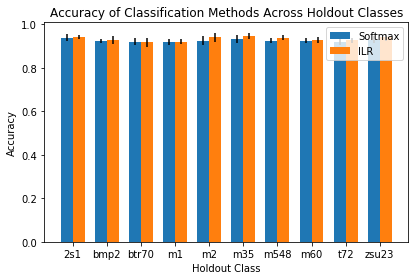

In [68]:
labels = [clsmap[i] for i in range(10)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

STAT_accuracy_np = np.array(STAT_accuracy)
STAT_accuracy_means = STAT_accuracy_np.mean(axis=1)
STAT_accuracy_std = STAT_accuracy_np.std(axis=1)
STAT_ilr_accuracy_np = np.array(STAT_ilr_accuracy)
STAT_ilr_accuracy_means = STAT_ilr_accuracy_np.mean(axis=1)
STAT_ilr_accuracy_std = STAT_ilr_accuracy_np.std(axis=1)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, STAT_accuracy_means, width,
                yerr=STAT_accuracy_std, label="Softmax")
rects2 = ax.bar(x + width/2, STAT_ilr_accuracy_means, width,
                yerr=STAT_ilr_accuracy_std, label="ILR")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Holdout Class')
ax.set_title('Accuracy of Classification Methods Across Holdout Classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [69]:
print("Average Softmax accuracy across holdout classes: ", STAT_accuracy_means.mean())
print("Average Softmax std across holdout classes: ", STAT_accuracy_std.mean())
print("Average ILR accuracy across holdout classes: ", STAT_ilr_accuracy_means.mean())
print("Average ILR std across holdout classes: ", STAT_ilr_accuracy_std.mean())

Average Softmax accuracy across holdout classes:  0.9263496656794599
Average Softmax std across holdout classes:  0.014391729658120573
Average ILR accuracy across holdout classes:  0.9333008814437157
Average ILR std across holdout classes:  0.014207119072825977


In [70]:
def getHistData(data, getDetAcc=False):
    tnr_mean = []
    tnr_std = []
    auroc_mean = []
    auroc_std = []
    dtacc_mean = []
    dtacc_std = []
    for i in range(10):
        temp_auroc = np.array(data[i]['holdout']['auroc'])
        temp_tnr = np.array(data[i]['holdout']['tnr'])
        temp_dtacc = np.array(data[i]['holdout']['dtacc'])
        auroc_mean.append(temp_auroc.mean())
        auroc_std.append(temp_auroc.std())
        tnr_mean.append(temp_tnr.mean())
        tnr_std.append(temp_tnr.std())
        if getDetAcc:
            dtacc_mean.append(temp_dtacc.mean())
            dtacc_std.append(temp_dtacc.std())
    tnr_mean = np.array(tnr_mean).mean()
    tnr_std = np.array(tnr_std).mean()
    auroc_mean = np.array(auroc_mean).mean()
    auroc_std = np.array(auroc_std).mean()
    if getDetAcc:
        dtacc_mean = np.array(dtacc_mean).mean()
        dtacc_std = np.array(dtacc_std).mean()
    else:
        dtacc_mean = 0.
        dtacc_std = 0.
    return tnr_mean, tnr_std, auroc_mean, auroc_std, dtacc_mean, dtacc_std

In [71]:
soft_base = getHistData(STAT_ood_baseline, getDetAcc=True)
soft_odin = getHistData(STAT_ood_odin, getDetAcc=True)
soft_odin_ipp = getHistData(STAT_ood_odin_ipp, getDetAcc=True)
soft_mahala = getHistData(STAT_ood_mahala, getDetAcc=True)
soft_mahala_ipp = getHistData(STAT_ood_mahala_ipp, getDetAcc=False)
ilr_base = getHistData(STAT_ilr_ood_baseline, getDetAcc=True)
ilr_odin = getHistData(STAT_ilr_ood_odin, getDetAcc=True)
ilr_odin_ipp = getHistData(STAT_ilr_ood_odin_ipp, getDetAcc=True)
ilr_mahala = getHistData(STAT_ilr_ood_mahala, getDetAcc=True)
ilr_mahala_ipp = getHistData(STAT_ilr_ood_mahala_ipp, getDetAcc=False)

soft_tnr_means = [soft_base[0], soft_odin[0], soft_odin_ipp[0], soft_mahala[0], soft_mahala_ipp[0]]
soft_tnr_std = [soft_base[1], soft_odin[1], soft_odin_ipp[1], soft_mahala[1], soft_mahala_ipp[1]]
soft_auroc_means = [soft_base[2], soft_odin[2], soft_odin_ipp[2], soft_mahala[2], soft_mahala_ipp[2]]
soft_auroc_std = [soft_base[3], soft_odin[3], soft_odin_ipp[3], soft_mahala[3], soft_mahala_ipp[3]]
soft_dtacc_means = [soft_base[4], soft_odin[4], soft_odin_ipp[4], soft_mahala[4]]
soft_dtacc_std = [soft_base[5], soft_odin[5], soft_odin_ipp[5], soft_mahala[5]]

ilr_tnr_means = [ilr_base[0], ilr_odin[0], ilr_odin_ipp[0], ilr_mahala[0], ilr_mahala_ipp[0]]
ilr_tnr_std = [ilr_base[1], ilr_odin[1], ilr_odin_ipp[1], ilr_mahala[1], ilr_mahala_ipp[1]]
ilr_auroc_means = [ilr_base[2], ilr_odin[2], ilr_odin_ipp[2], ilr_mahala[2], ilr_mahala_ipp[2]]
ilr_auroc_std = [ilr_base[3], ilr_odin[3], ilr_odin_ipp[3], ilr_mahala[3], ilr_mahala_ipp[3]]
ilr_dtacc_means = [ilr_base[4], ilr_odin[4], ilr_odin_ipp[4], ilr_mahala[4]]
ilr_dtacc_std = [ilr_base[5], ilr_odin[5], ilr_odin_ipp[5], ilr_mahala[5]]

In [72]:
soft_tnr_means

[0.17063889782928837,
 0.2315352455380831,
 0.2215320554727071,
 0.1462954407727758,
 0.148783819117958]

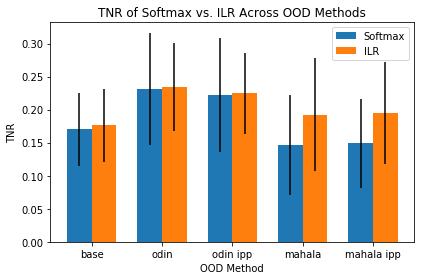

In [73]:
labels = ['base', 'odin', 'odin ipp', 'mahala', 'mahala ipp']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, soft_tnr_means, width,
                yerr=soft_tnr_std, label="Softmax")
rects2 = ax.bar(x + width/2, ilr_tnr_means, width,
                yerr=ilr_tnr_std, label="ILR")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('TNR')
ax.set_xlabel('OOD Method')
ax.set_title('TNR of Softmax vs. ILR Across OOD Methods')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

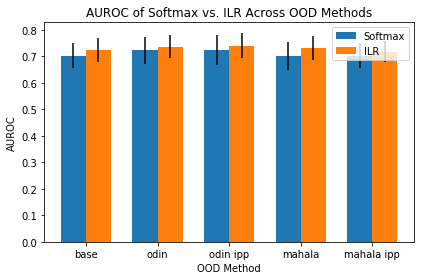

In [74]:
labels = ['base', 'odin', 'odin ipp', 'mahala', 'mahala ipp']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, soft_auroc_means, width,
                yerr=soft_auroc_std, label="Softmax")
rects2 = ax.bar(x + width/2, ilr_auroc_means, width,
                yerr=ilr_auroc_std, label="ILR")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUROC')
ax.set_xlabel('OOD Method')
ax.set_title('AUROC of Softmax vs. ILR Across OOD Methods')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

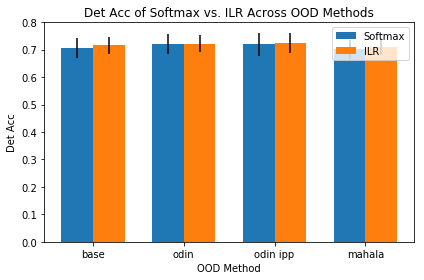

In [75]:
labels = ['base', 'odin', 'odin ipp', 'mahala']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, soft_dtacc_means, width,
                yerr=soft_dtacc_std, label="Softmax")
rects2 = ax.bar(x + width/2, ilr_dtacc_means, width,
                yerr=ilr_dtacc_std, label="ILR")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Det Acc')
ax.set_xlabel('OOD Method')
ax.set_title('Det Acc of Softmax vs. ILR Across OOD Methods')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()